In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.001,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


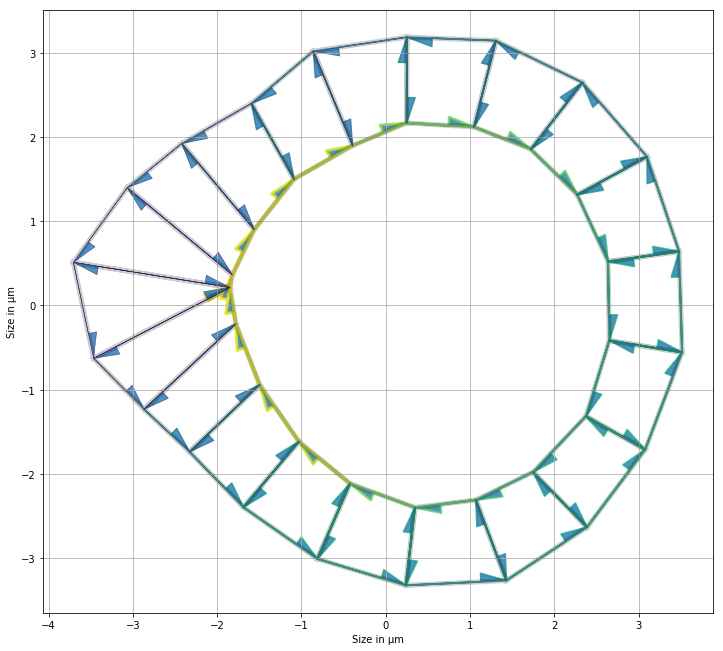

In [3]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.080, 0.082, 0.084, 0.085, 0.085,
    0.088, 0.085, 0.083, 0.081, 0.075,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [4]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

In [5]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.150
1     0.165
2     0.180
3     0.195
4     0.210
5     0.240
6     0.246
7     0.252
8     0.255
9     0.255
10    0.264
11    0.255
12    0.249
13    0.243
14    0.225
15    0.210
16    0.204
17    0.195
18    0.171
19    0.156
20    0.150
21    0.165
22    0.150
23    0.135
24    0.150
25    0.150
26    0.135
27    0.105
28    0.060
29    0.030
      ...  
50    0.030
51    0.042
52    0.063
53    0.108
54    0.087
55    0.123
56    0.117
57    0.129
58    0.138
59    0.153
60    0.165
61    0.150
62    0.132
63    0.153
64    0.153
65    0.138
66    0.102
67    0.057
68    0.027
69    0.030
70    0.042
71    0.063
72    0.108
73    0.087
74    0.123
75    0.117
76    0.129
77    0.138
78    0.153
79    0.150
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.152638
1     0.165052
2     0.153165
3     0.152784
4     0.161032
5     0.161876
6     0.131692
7     0.090826
8     0.052419
9     0.040853
10    0.046481
11    0.057820
12    0.082495
13    0.114963

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [6]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Matrice sans modification

Apical tensions:  [0.14052282 0.02690621 0.04082869 0.00488192 0.02661279 0.01531296
 0.01314241 0.01667314 0.01981094 0.00320414 0.02427704 0.0116447
 0.01511968 0.         0.02567961 0.01262475 0.04693408 0.036908
 0.02865824 0.        ] 
Basal tensions:  [0.13259424 0.0648713  0.06426289 0.03543242 0.04967711 0.03503369
 0.02978834 0.0266129  0.02198457 0.00392699 0.02237247 0.01412002
 0.01972117 0.00978494 0.03033846 0.02769423 0.05364594 0.05220093
 0.05517182 0.04286395] 
Lateral tensions:  [0.19577107 0.23574955 0.1025449  0.06101865 0.05306526 0.05557216
 0.03617928 0.02881309 0.01896941 0.00130555 0.         0.01396457
 0.01381349 0.01520046 0.01687992 0.03905576 0.05622782 0.08589797
 0.08720813 0.07073718] 
Area elasticity:  [0.33098366 0.10889923 0.11136465 0.04204576 0.07917567 0.04829651
 0.03642169 0.02947429 0.02190073 0.         0.02347718 0.01329994
 0.02449207 0.00396213 0.04660366 0.03554579 0.09717055 0.09232949
 0.09475639 0.05117704] 
Lumen area elasticity:  0.0

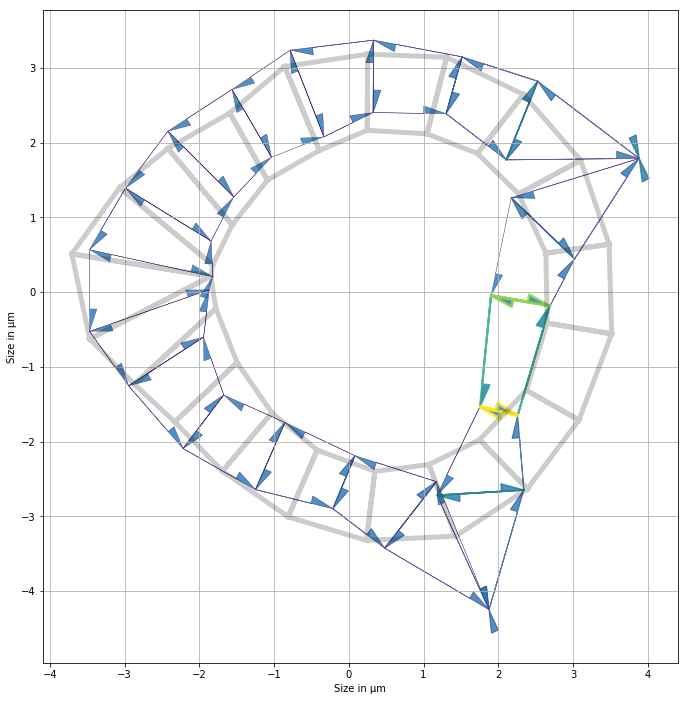

In [7]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
no_mod_mat, residuals = nnls(matrix, constant)
organo3_no_mod_mat = organo3.copy()
organo3_no_mod_mat.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_no_mod_mat,
                                                                     no_mod_mat[:3*organo3.Nf])
organo3_no_mod_mat.face_df.loc[:, 'prefered_area'] = organo3_no_mod_mat.face_df.area + no_mod_mat[3*organo3.Nf:
                                                                                                  4*organo3.Nf]
organo3_no_mod_mat.settings['lumen_prefered_vol'] = organo3_no_mod_mat.settings['lumen_volume'] + no_mod_mat[-1]
Solver.find_energy_min(organo3_no_mod_mat, geom, model)
print_tensions(organo3_no_mod_mat, organo3)
print('Apical tensions: ', no_mod_mat[organo3.apical_edges],
      '\nBasal tensions: ', no_mod_mat[organo3.basal_edges],
      '\nLateral tensions: ', no_mod_mat[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', no_mod_mat[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', no_mod_mat[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-no_mod_mat),
      '\nNNLS residuals: ', residuals)

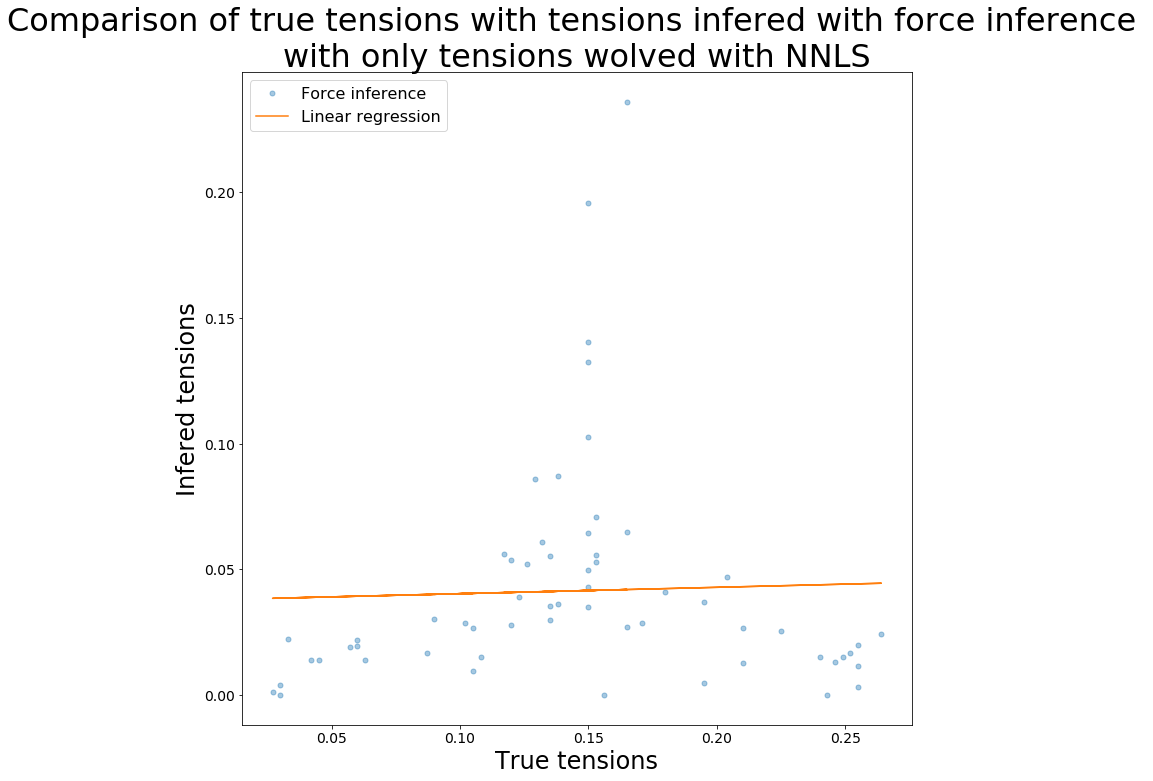

R value : 0.03704582861900419 
Standard error : 0.03792801299391285


In [8]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  no_mod_mat[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

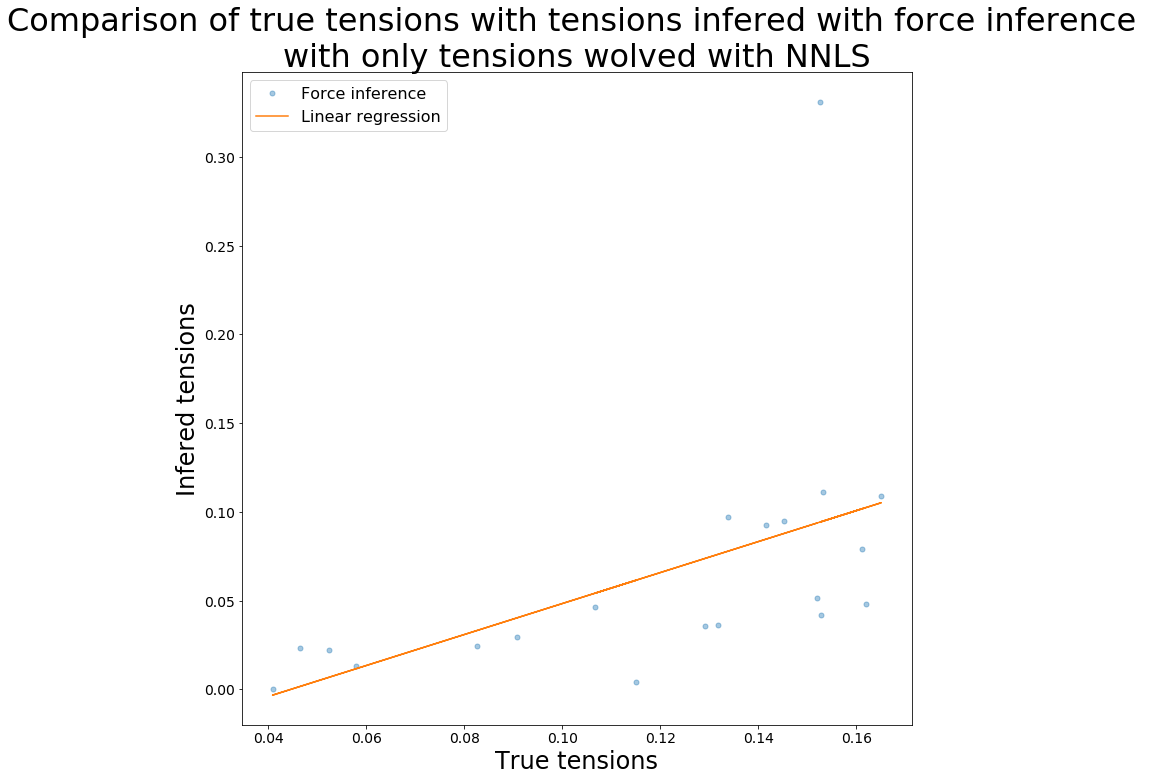

R value : 0.513146099118554 
Standard error : 0.030012407151738616


In [9]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  no_mod_mat[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec la dernière ligne "splitée" en deux contraintes
On supprime la contrainte $$\sum \Lambda_{i,j} = c$$ On ajoute les contraintes $$\Lambda_0 + \Lambda_1 + \Lambda_2 = c_1$$ $$\Lambda_6 + \Lambda_7 + \Lambda_8 = c_3$$ Où $c_3 = c_1*\frac{1-\rho}{\rho}$ et $\rho = \frac{\overline \ell_{api}}{\overline \ell_{api} + \overline \ell_{lat}}$ où $\overline \ell_{api}$ (resp. $\overline \ell_{lat}$) est la longueur moyenne des edges apicaux (resp. latéraux).

Apical tensions:  [0.0372975  0.01733531 0.07104491 0.00603071 0.03081881 0.00553522
 0.02044863 0.09184697 0.15656553 0.0278899  0.63055878 0.14146389
 0.12358442 0.00319182 0.06890085 0.00405804 0.04026508 0.02411924
 0.03225182 0.00935623] 
Basal tensions:  [0.09099381 0.07924217 0.11236869 0.07048044 0.08982626 0.07480702
 0.09123665 0.14954585 0.17692898 0.04413984 0.5455814  0.16558958
 0.16230657 0.06848949 0.11515068 0.06998215 0.09367001 0.08269125
 0.08855647 0.07352687] 
Lateral tensions:  [0.         0.01628726 0.04153522 0.02091721 0.         0.
 0.         0.07138006 0.11245068 0.00310911 0.04751039 0.34700565
 0.12384481 0.09085674 0.00777431 0.03513338 0.         0.01779035
 0.01139473 0.        ] 
Area elasticity:  [0.05397314 0.01799591 0.1124955  0.00080858 0.04671313 0.00524806
 0.03836179 0.13337648 0.16226578 0.         0.64206408 0.16095897
 0.18057111 0.         0.10117884 0.         0.05848041 0.03093925
 0.04496633 0.        ] 
Lumen area elasticity:  0.173170

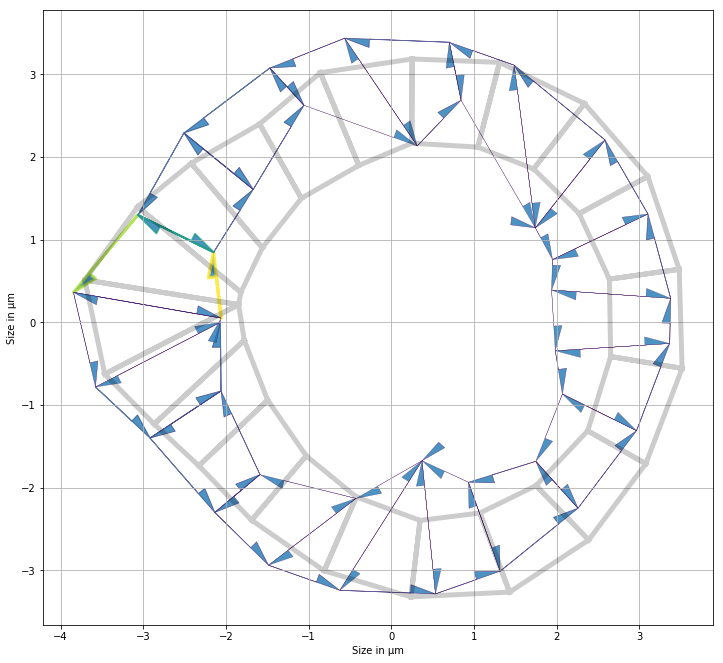

In [10]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
rapport_lenght = (organo3.edge_df.length[organo3.apical_edges].mean() /
                  (organo3.edge_df.length[organo3.apical_edges].mean() +
                   organo3.edge_df.length[organo3.lateral_edges].mean()))
constant[-1] = (organo3.edge_df.line_tension.mean() /
               (organo3.face_df.area_elasticity.mean() *
                organo3.face_df.prefered_area.mean()**1.5))*(1-rapport_lenght) * organo3.apical_edges.shape[0]
constant = np.concatenate((constant, [(organo3.lateral_edges.shape[0]/2 *
                                       rapport_lenght *
                                       organo3.edge_df.line_tension.mean() /
                                       (organo3.face_df.area_elasticity.mean() *
                                        organo3.face_df.prefered_area.mean()**1.5))]))
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[-1] = np.concatenate((np.ones(organo3.Nf),
                             np.zeros(3*organo3.Nf+1)))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(2*organo3.Nf), np.ones(organo3.Nf), np.zeros(organo3.Nf+1)))))
mat_2_cst, residuals = nnls(matrix, constant)
organo3_mat_2_cst = organo3.copy()
organo3_mat_2_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mat_2_cst,
                                                                    mat_2_cst[:3*organo3.Nf])
organo3_mat_2_cst.face_df.loc[:, 'prefered_area'] = organo3_mat_2_cst.face_df.area + mat_2_cst[3*organo3.Nf:
                                                                                                4*organo3.Nf]
organo3_mat_2_cst.settings['lumen_prefered_vol'] = organo3_mat_2_cst.settings['lumen_volume'] + mat_2_cst[-1]
Solver.find_energy_min(organo3_mat_2_cst, geom, model)
print_tensions(organo3_mat_2_cst, organo3)
print('Apical tensions: ', mat_2_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_2_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_2_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_2_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_2_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_2_cst),
      '\nNNLS residuals: ', residuals,
      '\nDistance from th mesh to exp mesh: ', np.sum(np.linalg.norm(_distance(organo3, organo3_mat_2_cst), axis=1)))

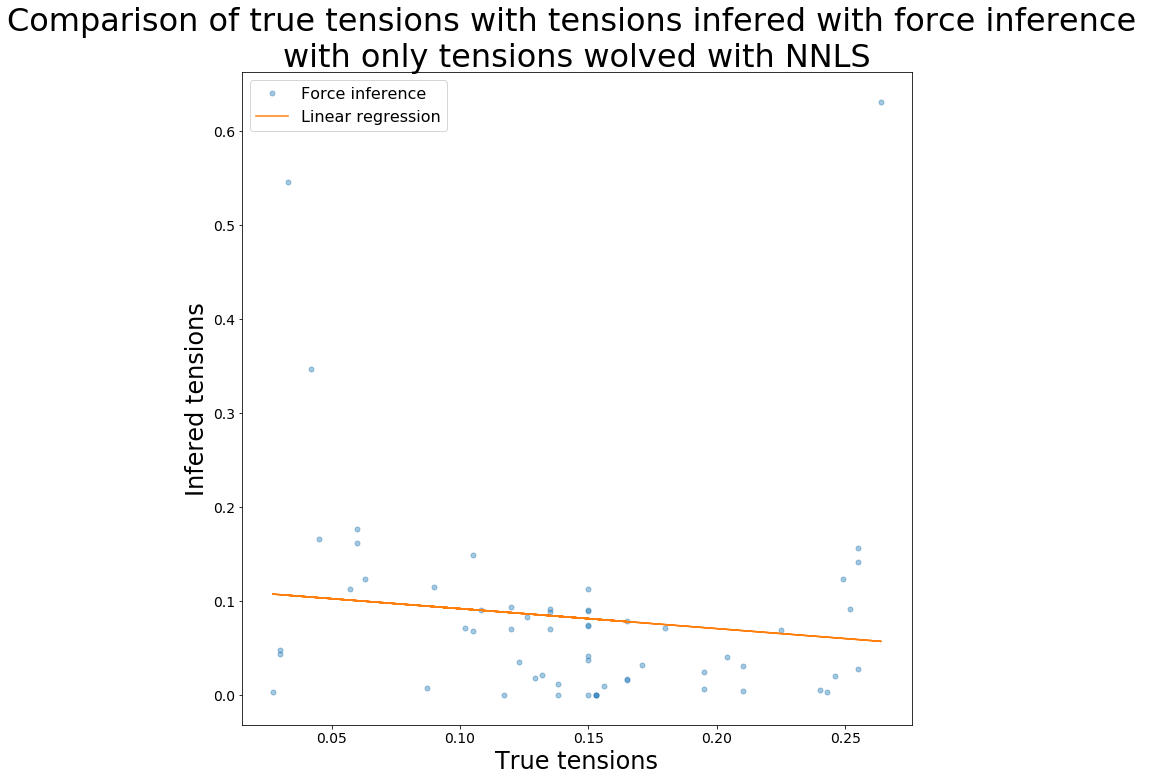

R value : -0.12118161757375641 
Standard error : 0.09662967987429993


In [11]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_2_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

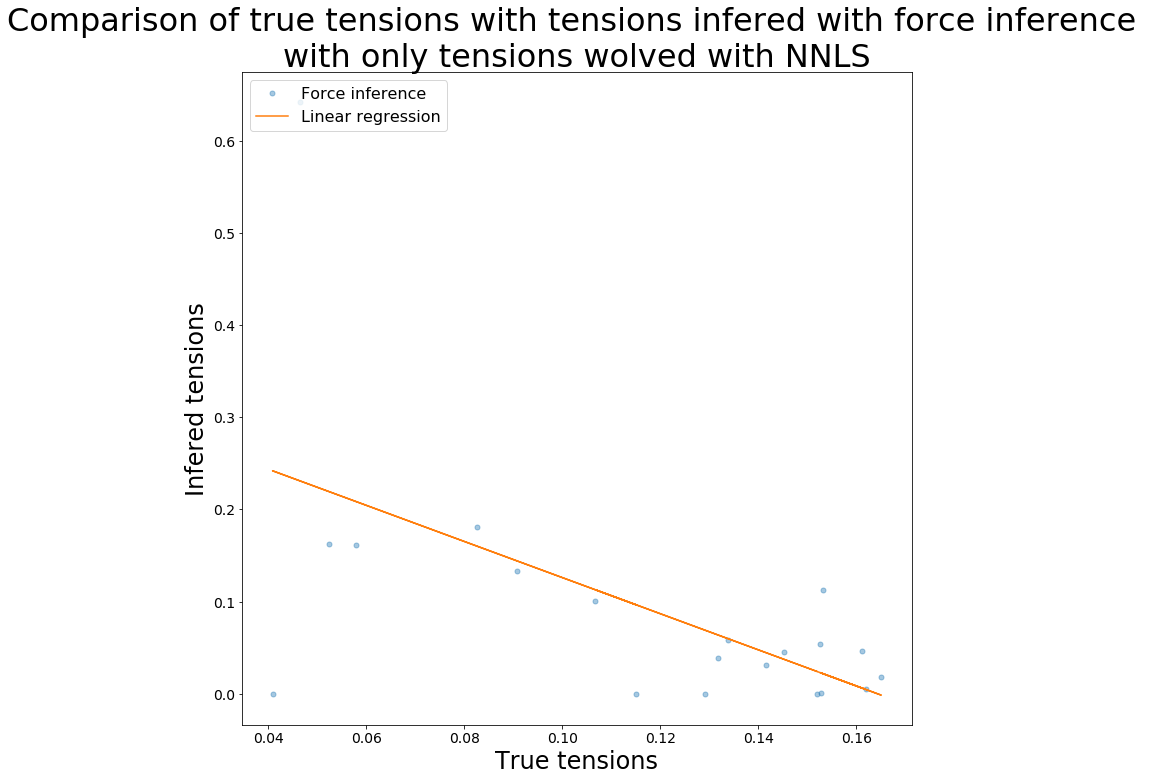

R value : -0.5762340518284285 
Standard error : 0.057123304901487405


In [12]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  mat_2_cst[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Minimize the distance wrt tensions

In [13]:
iprint_file = "../../assets/dist_at_each_f_ev/4_03_2_cst_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_2_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_2_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_2_cst[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

20.02883474661664 [0.60878284 0.4879404  0.24209452 0.35732458 0.67210611 0.78828276
 0.71730318 0.92287684 0.70485698 0.32872817 0.28738431 0.58178664
 0.71184977 1.13068863 0.70547027 0.67675564 0.94936731 0.57033249
 0.56418739 0.6331497  0.30377366 0.40411034 0.36589702 0.26678394
 0.29996908 0.30122086 0.63780602 0.62253345 0.20261317 0.21302245
 0.21553248 0.1131687  0.37169618 0.68312514 0.52420539 0.51445962
 0.26155811 0.4518138  0.37943238 0.25484443 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

20.028834693934293 [0.60878284 0.48794039 0.24209452 0.35732458 0.6721061  0.78828276
 0.71730317 0.92287685 0.70485698 0.32872817 0.28738431 0.58178664
 0.71184977 1.13068863 0.70547027 0.67675563 0.9493673  0.57033248
 0.56418739 0.6331497  0.30377366 0.40411034 0.36589702 0.26678394
 0.29996907 0.30122086 0.63780603 0.62253345 0.20261318 0.21302244
 0.21553248 0.1131687  0.37169618 0.68312514 0.52420539 0.51445962
 0.26155811 0.4518138  0.37943237 0.25484443 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

20.028832876087304 [0.60878278 0.4879403  0.24209441 0.35732459 0.67210613 0.78828246
 0.71730294 0.9228771  0.70485674 0.32872816 0.28738424 0.58178645
 0.71184973 1.13068885 0.70547017 0.67675529 0.94936695 0.57033234
 0.56418727 0.6331496  0.30377366 0.40411031 0.36589699 0.26678386
 0.29996894 0.30122099 0.63780617 0.62253332 0.20261342 0.2130223
 0.21553273 0.11316878 0.37169623 0.68312515 0.52420529 0.51445978
 0.26155825 0.45181374 0.37943218 0.25484428 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

20.02883474012288 [0.60878284 0.4879404  0.24209452 0.35732458 0.67210611 0.78828277
 0.71730318 0.92287684 0.70485698 0.32872817 0.28738431 0.58178664
 0.71184977 1.13068863 0.70547027 0.67675564 0.9493673  0.57033248
 0.56418739 0.6331497  0.30377366 0.40411034 0.36589702 0.26678394
 0.29996908 0.30122086 0.63780602 0.62253345 0.20261317 0.21302245
 0.21553247 0.1131687  0.37169618 0.68312514 0.52420539 0.51445962
 0.26155811 0.4518138  0.37943238 0.25484443 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

20.02883469396795 [0.60878284 0.4879404  0.24209452 0.35732458 0.67210611 0.78828275
 0.71730317 0.92287685 0.70485697 0.32872817 0.28738431 0.58178663
 0.71184977 1.13068864 0.70547026 0.67675563 0.94936729 0.57033248
 0.56418739 0.6331497  0.30377365 0.40411033 0.36589703 0.26678394
 0.29996908 0.30122087 0.63780603 0.62253344 0.20261318 0.21302244
 0.21553249 0.11316871 0.37169619 0.68312514 0.52420539 0.51445963
 0.26155811 0.4518138  0.37943237 0.25484443 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

20.028832811920154 [0.60878278 0.4879403  0.24209441 0.35732459 0.67210612 0.78828246
 0.71730295 0.92287708 0.70485675 0.32872816 0.28738424 0.58178646
 0.71184973 1.13068883 0.70547017 0.67675531 0.94936696 0.57033234
 0.56418727 0.63314959 0.30377366 0.40411031 0.36589699 0.26678386
 0.29996895 0.30122098 0.63780616 0.62253332 0.20261341 0.21302232
 0.21553271 0.11316878 0.37169623 0.68312514 0.5242053  0.51445977
 0.26155824 0.45181373 0.37943219 0.25484429 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

20.028833413000935 [0.6087828  0.48794033 0.24209445 0.35732458 0.6721061  0.78828257
 0.71730303 0.92287701 0.70485683 0.32872816 0.28738427 0.58178652
 0.71184974 1.13068875 0.70547022 0.67675541 0.94936707 0.57033238
 0.56418731 0.63314962 0.30377365 0.40411032 0.365897   0.26678389
 0.29996899 0.30122094 0.63780612 0.62253337 0.20261333 0.21302236
 0.21553262 0.11316875 0.37169621 0.68312514 0.52420533 0.51445972
 0.2615582  0.45181375 0.37943225 0.25484433 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

20.028835051736543 [0.60878285 0.48794041 0.24209453 0.35732458 0.6721061  0.7882828
 0.7173032  0.92287682 0.70485701 0.32872818 0.28738432 0.58178666
 0.71184978 1.13068861 0.70547028 0.67675568 0.94936735 0.5703325
 0.56418741 0.63314972 0.30377368 0.40411034 0.36589703 0.26678395
 0.29996909 0.30122085 0.63780601 0.62253346 0.20261315 0.21302246
 0.21553245 0.1131687  0.37169618 0.68312514 0.5242054  0.5144596
 0.26155809 0.45181381 0.3794324  0.25484448 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

20.028798629913297 [0.60878164 0.48793875 0.24209273 0.35732448 0.67210538 0.78827758
 0.71729965 0.92288007 0.70485325 0.32872781 0.28738343 0.58178351
 0.71184894 1.13069125 0.70546881 0.67675014 0.94936151 0.57032984
 0.56418547 0.63314766 0.30377361 0.40410986 0.36589615 0.26678289
 0.29996725 0.30122257 0.63780805 0.62253131 0.20261685 0.21302077
 0.21553547 0.11316978 0.37169678 0.68312511 0.52420419 0.51446196
 0.26156018 0.45181274 0.37942925 0.25484195 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

20.028815347971413 [0.60878222 0.48793944 0.24209345 0.35732465 0.67210616 0.78827982
 0.71730096 0.92287922 0.70485469 0.32872798 0.28738368 0.58178483
 0.71184933 1.13069057 0.70546933 0.67675231 0.9493638  0.57033102
 0.56418616 0.63314858 0.30377364 0.40411004 0.36589664 0.26678321
 0.29996779 0.30122201 0.63780737 0.62253222 0.20261549 0.21302118
 0.21553476 0.11316944 0.3716966  0.68312518 0.52420449 0.51446111
 0.26155943 0.45181313 0.37943046 0.25484297 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

20.028834631886458 [0.60878284 0.48794039 0.24209452 0.35732458 0.67210611 0.78828275
 0.71730317 0.92287685 0.70485697 0.32872817 0.28738431 0.58178663
 0.71184977 1.13068863 0.70547026 0.67675562 0.94936728 0.57033247
 0.56418739 0.6331497  0.30377365 0.40411034 0.36589702 0.26678394
 0.29996907 0.30122087 0.63780603 0.62253344 0.20261318 0.21302244
 0.21553248 0.11316871 0.37169619 0.68312514 0.52420539 0.51445963
 0.26155811 0.4518138  0.37943237 0.25484443 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

20.02883474661664 [0.60878284 0.4879404  0.24209452 0.35732458 0.67210611 0.78828276
 0.71730318 0.92287684 0.70485698 0.32872817 0.28738431 0.58178664
 0.71184977 1.13068863 0.70547027 0.67675564 0.94936731 0.57033249
 0.56418739 0.6331497  0.30377366 0.40411034 0.36589702 0.26678394
 0.29996908 0.30122086 0.63780602 0.62253345 0.20261317 0.21302245
 0.21553248 0.1131687  0.37169618 0.68312514 0.52420539 0.51445962
 0.26155811 0.4518138  0.37943238 0.25484443 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

20.02883474661664 [0.60878284 0.4879404  0.24209452 0.35732458 0.67210611 0.78828276
 0.71730318 0.92287684 0.70485698 0.32872817 0.28738431 0.58178664
 0.71184977 1.13068863 0.70547027 0.67675564 0.94936731 0.57033249
 0.56418739 0.6331497  0.30377366 0.40411034 0.36589702 0.26678394
 0.29996908 0.30122086 0.63780602 0.62253345 0.20261317 0.21302245
 0.21553248 0.1131687  0.37169618 0.68312514 0.52420539 0.51445962
 0.26155811 0.4518138  0.37943238 0.25484443 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

20.02883474661664 [0.60878284 0.4879404  0.24209452 0.35732458 0.67210611 0.78828276
 0.71730318 0.92287684 0.70485698 0.32872817 0.28738431 0.58178664
 0.71184977 1.13068863 0.70547027 0.67675564 0.94936731 0.57033249
 0.56418739 0.6331497  0.30377366 0.40411034 0.36589702 0.26678394
 0.29996908 0.30122086 0.63780602 0.62253345 0.20261317 0.21302245
 0.21553248 0.1131687  0.37169618 0.68312514 0.52420539 0.51445962
 0.26155811 0.4518138  0.37943238 0.25484443 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

20.028840569227025 [0.60878302 0.4879407  0.24209484 0.35732455 0.67210605 0.78828368
 0.71730389 0.92287609 0.70485771 0.32872824 0.28738452 0.58178721
 0.71184991 1.13068799 0.70547057 0.67675667 0.94936838 0.57033292
 0.56418778 0.63315003 0.30377365 0.40411043 0.36589713 0.26678418
 0.29996948 0.30122048 0.63780561 0.62253384 0.20261244 0.21302287
 0.21553171 0.11316847 0.37169604 0.68312512 0.5242057  0.51445915
 0.2615577  0.451814   0.37943297 0.25484487 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

20.028846337372535 [0.60878322 0.48794096 0.24209515 0.35732456 0.6721062  0.78828443
 0.71730438 0.9228755  0.70485824 0.32872826 0.28738465 0.5817877
 0.71185005 1.13068758 0.70547076 0.67675758 0.94936939 0.5703334
 0.56418811 0.63315038 0.30377368 0.40411049 0.36589727 0.2667843
 0.29996979 0.30122026 0.63780523 0.62253413 0.2026119  0.21302309
 0.21553135 0.11316829 0.371696   0.68312512 0.52420582 0.51445876
 0.26155732 0.45181422 0.37943348 0.25484531 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

20.028851945342904 [0.60878338 0.48794126 0.2420955  0.35732449 0.67210607 0.78828544
 0.71730517 0.92287459 0.70485906 0.32872831 0.28738492 0.58178832
 0.71185018 1.13068679 0.70547109 0.6767587  0.94937052 0.57033382
 0.56418851 0.6331507  0.30377366 0.40411058 0.36589736 0.26678459
 0.29997023 0.30121981 0.63780475 0.62253454 0.20261106 0.21302361
 0.21553044 0.11316803 0.37169583 0.68312506 0.52420619 0.51445821
 0.26155685 0.45181441 0.37943412 0.25484578 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

20.028839445283094 [0.60878299 0.48794063 0.24209478 0.35732456 0.67210607 0.7882835
 0.71730374 0.92287625 0.70485756 0.32872823 0.28738447 0.58178709
 0.71184988 1.13068813 0.70547051 0.67675646 0.94936816 0.57033283
 0.5641877  0.63314997 0.30377365 0.40411041 0.36589711 0.26678413
 0.2999694  0.30122056 0.63780569 0.62253376 0.20261259 0.21302278
 0.21553187 0.11316852 0.37169607 0.68312513 0.52420563 0.51445925
 0.26155778 0.45181396 0.37943285 0.25484478 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

18.545741734114102 [8.37393849e-01 4.30762229e-01 2.28749614e-01 3.66931404e-01
 3.41924163e-01 1.42893675e+00 1.30273382e+00 5.72234517e-01
 6.47360517e-01 7.00256054e-01 1.11389456e-01 4.59520795e-01
 5.31335288e-01 8.62076167e-01 3.05380767e-01 1.53282854e-01
 3.15193135e-01 5.13925197e-01 4.38216175e-01 6.81179735e-01
 6.60907985e-02 3.85206768e-01 3.42291419e-01 2.17394450e-01
 4.20662737e-01 9.54220150e-01 4.51033440e-01 5.65825700e-01
 1.26709545e-01 6.15538584e-01 2.34607464e-01 7.46208232e-02
 2.86203960e-01 4.93198834e-01 4.61683790e-01 3.93305144e-01
 3.58358828e-01 3.03687190e-01 3.88612328e-01 1.67349236e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.54574179214758 [8.37393958e-01 4.30762070e-01 2.28749543e-01 3.66931414e-01
 3.41924438e-01 1.42893752e+00 1.30273459e+00 5.72234426e-01
 6.47360305e-01 7.00255773e-01 1.11389276e-01 4.59520735e-01
 5.31335294e-01 8.62076024e-01 3.05380814e-01 1.53282833e-01
 3.15193145e-01 5.13925027e-01 4.38216007e-01 6.81179764e-01
 6.60907454e-02 3.85206746e-01 3.42291325e-01 2.17394309e-01
 4.20662968e-01 9.54220676e-01 4.51033422e-01 5.65825479e-01
 1.26709303e-01 6.15538714e-01 2.34607095e-01 7.46208054e-02
 2.86204128e-01 4.93198789e-01 4.61683720e-01 3.93305146e-01
 3.58358842e-01 3.03687216e-01 3.88612301e-01 1.67349048e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

18.545749706604155 [8.37392737e-01 4.30764175e-01 2.28750549e-01 3.66931502e-01
 3.41921619e-01 1.42893017e+00 1.30272641e+00 5.72235434e-01
 6.47362547e-01 7.00259395e-01 1.11392019e-01 4.59521716e-01
 5.31335080e-01 8.62078202e-01 3.05379908e-01 1.53282786e-01
 3.15193363e-01 5.13927472e-01 4.38218265e-01 6.81179375e-01
 6.60913506e-02 3.85207282e-01 3.42292942e-01 2.17395978e-01
 4.20660805e-01 9.54215122e-01 4.51033641e-01 5.65827656e-01
 1.26712960e-01 6.15537131e-01 2.34611849e-01 7.46204958e-02
 2.86201662e-01 4.93199466e-01 4.61685178e-01 3.93304649e-01
 3.58359504e-01 3.03687056e-01 3.88612710e-01 1.67351478e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.54574680387733 [8.37392838e-01 4.30763926e-01 2.28750421e-01 3.66931439e-01
 3.41921772e-01 1.42893040e+00 1.30272688e+00 5.72235371e-01
 6.47362390e-01 7.00258998e-01 1.11391619e-01 4.59521560e-01
 5.31335128e-01 8.62077887e-01 3.05380074e-01 1.53282869e-01
 3.15193251e-01 5.13927134e-01 4.38217984e-01 6.81179422e-01
 6.60912971e-02 3.85207163e-01 3.42292669e-01 2.17395822e-01
 4.20660861e-01 9.54215465e-01 4.51033634e-01 5.65827544e-01
 1.26712435e-01 6.15537295e-01 2.34611321e-01 7.46206392e-02
 2.86202003e-01 4.93199367e-01 4.61684898e-01 3.93304817e-01
 3.58359256e-01 3.03687039e-01 3.88612652e-01 1.67351201e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

18.54574241775204 [8.37393707e-01 4.30762472e-01 2.28749729e-01 3.66931408e-01
 3.41923817e-01 1.42893582e+00 1.30273281e+00 5.72234641e-01
 6.47360788e-01 7.00256476e-01 1.11389762e-01 4.59520903e-01
 5.31335266e-01 8.62076411e-01 3.05380671e-01 1.53282858e-01
 3.15193149e-01 5.13925476e-01 4.38216432e-01 6.81179689e-01
 6.60908697e-02 3.85206824e-01 3.42291596e-01 2.17394646e-01
 4.20662463e-01 9.54219472e-01 4.51033469e-01 5.65825967e-01
 1.26709955e-01 6.15538400e-01 2.34608016e-01 7.46207995e-02
 2.86203682e-01 4.93198910e-01 4.61683945e-01 3.93305101e-01
 3.58358886e-01 3.03687166e-01 3.88612374e-01 1.67349518e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

18.545739784920894 [8.37394034e-01 4.30761879e-01 2.28749450e-01 3.66931369e-01
 3.41924572e-01 1.42893777e+00 1.30273502e+00 5.72234367e-01
 6.47360178e-01 7.00255456e-01 1.11388970e-01 4.59520618e-01
 5.31335332e-01 8.62075785e-01 3.05380940e-01 1.53282886e-01
 3.15193072e-01 5.13924773e-01 4.38215794e-01 6.81179802e-01
 6.60907053e-02 3.85206656e-01 3.42291127e-01 2.17394189e-01
 4.20663035e-01 9.54220978e-01 4.51033411e-01 5.65825383e-01
 1.26708902e-01 6.15538840e-01 2.34606677e-01 7.46209100e-02
 2.86204389e-01 4.93198715e-01 4.61683509e-01 3.93305263e-01
 3.58358663e-01 3.03687206e-01 3.88612259e-01 1.67348834e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545744441395726 [8.37393168e-01 4.30763352e-01 2.28750147e-01 3.66931408e-01
 3.41922520e-01 1.42893233e+00 1.30272908e+00 5.72235103e-01
 6.47361779e-01 7.00258010e-01 1.11390861e-01 4.59521287e-01
 5.31335184e-01 8.62077290e-01 3.05380333e-01 1.53282887e-01
 3.15193181e-01 5.13926462e-01 4.38217365e-01 6.81179528e-01
 6.60911316e-02 3.85207012e-01 3.42292221e-01 2.17395369e-01
 4.20661440e-01 9.54216928e-01 4.51033593e-01 5.65826959e-01
 1.26711430e-01 6.15537724e-01 2.34610027e-01 7.46207286e-02
 2.86202679e-01 4.93199180e-01 4.61684489e-01 3.93304960e-01
 3.58359067e-01 3.03687079e-01 3.88612541e-01 1.67350540e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545756392730024 [8.37390921e-01 4.30767136e-01 2.28751949e-01 3.66931501e-01
 3.41917245e-01 1.42891838e+00 1.30271376e+00 5.72236992e-01
 6.47365919e-01 7.00264578e-01 1.11395710e-01 4.59523010e-01
 5.31334822e-01 8.62081148e-01 3.05378781e-01 1.53282894e-01
 3.15193466e-01 5.13930796e-01 4.38221404e-01 6.81178831e-01
 6.60922377e-02 3.85207908e-01 3.42295030e-01 2.17398415e-01
 4.20657313e-01 9.54206599e-01 4.51034006e-01 5.65831029e-01
 1.26717904e-01 6.15534868e-01 2.34618631e-01 7.46202831e-02
 2.86198301e-01 4.93200376e-01 4.61686987e-01 3.93304198e-01
 3.58360071e-01 3.03686752e-01 3.88613267e-01 1.67354919e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.54574524455451 [8.37393536e-01 4.30762818e-01 2.28749903e-01 3.66931461e-01
 3.41923491e-01 1.42893511e+00 1.30273185e+00 5.72234768e-01
 6.47361073e-01 7.00257053e-01 1.11390275e-01 4.59521097e-01
 5.31335213e-01 8.62076809e-01 3.05380492e-01 1.53282789e-01
 3.15193252e-01 5.13925911e-01 4.38216814e-01 6.81179625e-01
 6.60909543e-02 3.85206955e-01 3.42291926e-01 2.17394890e-01
 4.20662260e-01 9.54218798e-01 4.51033492e-01 5.65826212e-01
 1.26710630e-01 6.15538163e-01 2.34608776e-01 7.46206652e-02
 2.86203240e-01 4.93199036e-01 4.61684259e-01 3.93304936e-01
 3.58359127e-01 3.03687170e-01 3.88612450e-01 1.67349910e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

18.54573982710403 [8.37394110e-01 4.30761778e-01 2.28749397e-01 3.66931379e-01
 3.41924747e-01 1.42893825e+00 1.30273552e+00 5.72234307e-01
 6.47360050e-01 7.00255279e-01 1.11388856e-01 4.59520579e-01
 5.31335337e-01 8.62075692e-01 3.05380969e-01 1.53282878e-01
 3.15193087e-01 5.13924665e-01 4.38215694e-01 6.81179815e-01
 6.60906696e-02 3.85206648e-01 3.42291062e-01 2.17394096e-01
 4.20663177e-01 9.54221305e-01 4.51033395e-01 5.65825251e-01
 1.26708747e-01 6.15538919e-01 2.34606445e-01 7.46209041e-02
 2.86204496e-01 4.93198686e-01 4.61683462e-01 3.93305263e-01
 3.58358671e-01 3.03687235e-01 3.88612231e-01 1.67348715e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

18.545736635085092 [8.37394974e-01 4.30760362e-01 2.28748733e-01 3.66931381e-01
 3.41926834e-01 1.42894387e+00 1.30274154e+00 5.72233568e-01
 6.47358439e-01 7.00252821e-01 1.11387103e-01 4.59519966e-01
 5.31335457e-01 8.62074291e-01 3.05381505e-01 1.53282822e-01
 3.15193025e-01 5.13923083e-01 4.38214192e-01 6.81180076e-01
 6.60902466e-02 3.85206349e-01 3.42290066e-01 2.17392933e-01
 4.20664839e-01 9.54225362e-01 4.51033222e-01 5.65823643e-01
 1.26706398e-01 6.15540003e-01 2.34603226e-01 7.46210009e-02
 2.86206094e-01 4.93198254e-01 4.61682604e-01 3.93305477e-01
 3.58358397e-01 3.03687362e-01 3.88611971e-01 1.67347080e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545737928302227 [8.37394454e-01 4.30761190e-01 2.28749117e-01 3.66931364e-01
 3.41925565e-01 1.42894041e+00 1.30273789e+00 5.72234014e-01
 6.47359406e-01 7.00254262e-01 1.11388103e-01 4.59520312e-01
 5.31335392e-01 8.62075093e-01 3.05381211e-01 1.53282873e-01
 3.15193031e-01 5.13923993e-01 4.38215061e-01 6.81179927e-01
 6.60904989e-02 3.85206507e-01 3.42290626e-01 2.17393623e-01
 4.20663817e-01 9.54222904e-01 4.51033331e-01 5.65824620e-01
 1.26707743e-01 6.15539364e-01 2.34605113e-01 7.46209720e-02
 2.86205175e-01 4.93198501e-01 4.61683075e-01 3.93305382e-01
 3.58358508e-01 3.03687269e-01 3.88612126e-01 1.67348037e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.54574206257866 [8.37393818e-01 4.30762288e-01 2.28749643e-01 3.66931410e-01
 3.41924095e-01 1.42893658e+00 1.30273362e+00 5.72234542e-01
 6.47360574e-01 7.00256154e-01 1.11389537e-01 4.59520825e-01
 5.31335281e-01 8.62076231e-01 3.05380738e-01 1.53282848e-01
 3.15193145e-01 5.13925268e-01 4.38216238e-01 6.81179724e-01
 6.60908143e-02 3.85206786e-01 3.42291469e-01 2.17394493e-01
 4.20662687e-01 9.54220012e-01 4.51033445e-01 5.65825752e-01
 1.26709653e-01 6.15538541e-01 2.34607595e-01 7.46208085e-02
 2.86203889e-01 4.93198854e-01 4.61683837e-01 3.93305124e-01
 3.58358856e-01 3.03687187e-01 3.88612339e-01 1.67349304e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

18.545676385041315 [8.37406427e-01 4.30741033e-01 2.28739533e-01 3.66930924e-01
 3.41953868e-01 1.42901540e+00 1.30281993e+00 5.72223933e-01
 6.47337231e-01 7.00219352e-01 1.11362323e-01 4.59511223e-01
 5.31337296e-01 8.62054617e-01 3.05389417e-01 1.53282769e-01
 3.15191567e-01 5.13900940e-01 4.38193566e-01 6.81183697e-01
 6.60846029e-02 3.85201795e-01 3.42275746e-01 2.17377357e-01
 4.20685975e-01 9.54278345e-01 4.51031017e-01 5.65802835e-01
 1.26673339e-01 6.15554642e-01 2.34559291e-01 7.46232551e-02
 2.86228410e-01 4.93192160e-01 4.61669864e-01 3.93309356e-01
 3.58353293e-01 3.03689023e-01 3.88608279e-01 1.67324691e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.54573515968581 [8.37395081e-01 4.30760148e-01 2.28748623e-01 3.66931353e-01
 3.41927065e-01 1.42894442e+00 1.30274223e+00 5.72233480e-01
 6.47358242e-01 7.00252452e-01 1.11386791e-01 4.59519851e-01
 5.31335488e-01 8.62074046e-01 3.05381621e-01 1.53282850e-01
 3.15192973e-01 5.13922809e-01 4.38213955e-01 6.81180119e-01
 6.60901912e-02 3.85206274e-01 3.42289874e-01 2.17392774e-01
 4.20665000e-01 9.54225838e-01 4.51033205e-01 5.65823464e-01
 1.26705986e-01 6.15540158e-01 2.34602740e-01 7.46210689e-02
 2.86206367e-01 4.93198177e-01 4.61682416e-01 3.93305564e-01
 3.58358270e-01 3.03687368e-01 3.88611928e-01 1.67346830e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

18.545741242824494 [8.37393955e-01 4.30762054e-01 2.28749531e-01 3.66931402e-01
 3.41924414e-01 1.42893742e+00 1.30273454e+00 5.72234428e-01
 6.47360322e-01 7.00255750e-01 1.11389234e-01 4.59520717e-01
 5.31335304e-01 8.62075990e-01 3.05380837e-01 1.53282851e-01
 3.15193124e-01 5.13924997e-01 4.38215988e-01 6.81179767e-01
 6.60907467e-02 3.85206728e-01 3.42291292e-01 2.17394307e-01
 4.20662933e-01 9.54220639e-01 4.51033420e-01 5.65825506e-01
 1.26709248e-01 6.15538717e-01 2.34607065e-01 7.46208405e-02
 2.86204161e-01 4.93198779e-01 4.61683678e-01 3.93305176e-01
 3.58358787e-01 3.03687206e-01 3.88612294e-01 1.67349033e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545741242824494 [8.37393955e-01 4.30762054e-01 2.28749531e-01 3.66931402e-01
 3.41924414e-01 1.42893742e+00 1.30273454e+00 5.72234428e-01
 6.47360322e-01 7.00255750e-01 1.11389234e-01 4.59520717e-01
 5.31335304e-01 8.62075990e-01 3.05380837e-01 1.53282851e-01
 3.15193124e-01 5.13924997e-01 4.38215988e-01 6.81179767e-01
 6.60907467e-02 3.85206728e-01 3.42291292e-01 2.17394307e-01
 4.20662933e-01 9.54220639e-01 4.51033420e-01 5.65825506e-01
 1.26709248e-01 6.15538717e-01 2.34607065e-01 7.46208405e-02
 2.86204161e-01 4.93198779e-01 4.61683678e-01 3.93305176e-01
 3.58358787e-01 3.03687206e-01 3.88612294e-01 1.67349033e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545741242824494 [8.37393955e-01 4.30762054e-01 2.28749531e-01 3.66931402e-01
 3.41924414e-01 1.42893742e+00 1.30273454e+00 5.72234428e-01
 6.47360322e-01 7.00255750e-01 1.11389234e-01 4.59520717e-01
 5.31335304e-01 8.62075990e-01 3.05380837e-01 1.53282851e-01
 3.15193124e-01 5.13924997e-01 4.38215988e-01 6.81179767e-01
 6.60907467e-02 3.85206728e-01 3.42291292e-01 2.17394307e-01
 4.20662933e-01 9.54220639e-01 4.51033420e-01 5.65825506e-01
 1.26709248e-01 6.15538717e-01 2.34607065e-01 7.46208405e-02
 2.86204161e-01 4.93198779e-01 4.61683678e-01 3.93305176e-01
 3.58358787e-01 3.03687206e-01 3.88612294e-01 1.67349033e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545741242824494 [8.37393955e-01 4.30762054e-01 2.28749531e-01 3.66931402e-01
 3.41924414e-01 1.42893742e+00 1.30273454e+00 5.72234428e-01
 6.47360322e-01 7.00255750e-01 1.11389234e-01 4.59520717e-01
 5.31335304e-01 8.62075990e-01 3.05380837e-01 1.53282851e-01
 3.15193124e-01 5.13924997e-01 4.38215988e-01 6.81179767e-01
 6.60907467e-02 3.85206728e-01 3.42291292e-01 2.17394307e-01
 4.20662933e-01 9.54220639e-01 4.51033420e-01 5.65825506e-01
 1.26709248e-01 6.15538717e-01 2.34607065e-01 7.46208405e-02
 2.86204161e-01 4.93198779e-01 4.61683678e-01 3.93305176e-01
 3.58358787e-01 3.03687206e-01 3.88612294e-01 1.67349033e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545741242824494 [8.37393955e-01 4.30762054e-01 2.28749531e-01 3.66931402e-01
 3.41924414e-01 1.42893742e+00 1.30273454e+00 5.72234428e-01
 6.47360322e-01 7.00255750e-01 1.11389234e-01 4.59520717e-01
 5.31335304e-01 8.62075990e-01 3.05380837e-01 1.53282851e-01
 3.15193124e-01 5.13924997e-01 4.38215988e-01 6.81179767e-01
 6.60907467e-02 3.85206728e-01 3.42291292e-01 2.17394307e-01
 4.20662933e-01 9.54220639e-01 4.51033420e-01 5.65825506e-01
 1.26709248e-01 6.15538717e-01 2.34607065e-01 7.46208405e-02
 2.86204161e-01 4.93198779e-01 4.61683678e-01 3.93305176e-01
 3.58358787e-01 3.03687206e-01 3.88612294e-01 1.67349033e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545946046476057 [8.37357498e-01 4.30823779e-01 2.28779048e-01 3.66933180e-01
 3.41839451e-01 1.42871313e+00 1.30248766e+00 5.72265092e-01
 6.47426884e-01 7.00362685e-01 1.11468278e-01 4.59549138e-01
 5.31329105e-01 8.62139216e-01 3.05355172e-01 1.53282597e-01
 3.15198058e-01 5.13995848e-01 4.38281925e-01 6.81168778e-01
 6.61087199e-02 3.85221781e-01 3.42337656e-01 2.17443743e-01
 4.20597050e-01 9.54053685e-01 4.51040140e-01 5.65891047e-01
 1.26815224e-01 6.15492072e-01 2.34746832e-01 7.46130148e-02
 2.86132160e-01 4.93218388e-01 4.61724939e-01 3.93292207e-01
 3.58376182e-01 3.03682021e-01 3.88624339e-01 1.67420262e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545958933927274 [8.37355791e-01 4.30826768e-01 2.28780501e-01 3.66933338e-01
 3.41835589e-01 1.42870317e+00 1.30247640e+00 5.72266518e-01
 6.47429954e-01 7.00367852e-01 1.11472216e-01 4.59550589e-01
 5.31328770e-01 8.62142371e-01 3.05353834e-01 1.53282484e-01
 3.15198411e-01 5.13999353e-01 4.38285148e-01 6.81168270e-01
 6.61095685e-02 3.85222598e-01 3.42340029e-01 2.17446090e-01
 4.20594151e-01 9.54046047e-01 4.51040437e-01 5.65894020e-01
 1.26820496e-01 6.15489846e-01 2.34753559e-01 7.46124850e-02
 2.86128576e-01 4.93219371e-01 4.61727094e-01 3.93291436e-01
 3.58377274e-01 3.03681827e-01 3.88624949e-01 1.67423692e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545803759594346 [8.37379119e-01 4.30786515e-01 2.28761137e-01 3.66931601e-01
 3.41889014e-01 1.42884251e+00 1.30263200e+00 5.72247083e-01
 6.47387688e-01 7.00298359e-01 1.11419886e-01 4.59531548e-01
 5.31333055e-01 8.62100540e-01 3.05371288e-01 1.53283452e-01
 3.15194289e-01 5.13952636e-01 4.38241977e-01 6.81175321e-01
 6.60980070e-02 3.85212135e-01 3.42308870e-01 2.17414277e-01
 4.20634910e-01 9.54151513e-01 4.51036332e-01 5.65852773e-01
 1.26750438e-01 6.15519998e-01 2.34662819e-01 7.46186643e-02
 2.86176158e-01 4.93206359e-01 4.61699037e-01 3.93301039e-01
 3.58364151e-01 3.03684832e-01 3.88616956e-01 1.67377409e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.546230502530737 [8.37303103e-01 4.30914659e-01 2.28822776e-01 3.66935224e-01
 3.41713323e-01 1.42837730e+00 1.30212041e+00 5.72311623e-01
 6.47524223e-01 7.00521187e-01 1.11582422e-01 4.59591302e-01
 5.31319566e-01 8.62232002e-01 3.05318015e-01 1.53283154e-01
 3.15203725e-01 5.14099298e-01 4.38378857e-01 6.81154195e-01
 6.61354401e-02 3.85243894e-01 3.42405527e-01 2.17516818e-01
 4.20499208e-01 9.53805805e-01 4.51049833e-01 5.65988634e-01
 1.26970125e-01 6.15423017e-01 2.34952174e-01 7.46023824e-02
 2.86025252e-01 4.93247143e-01 4.61784457e-01 3.93274422e-01
 3.58400674e-01 3.03673879e-01 3.88642604e-01 1.67524795e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

18.545914167457816 [8.37362180e-01 4.30815673e-01 2.28775146e-01 3.66932812e-01
 3.41850125e-01 1.42874094e+00 1.30251878e+00 5.72261188e-01
 6.47418444e-01 7.00348702e-01 1.11457751e-01 4.59545284e-01
 5.31329985e-01 8.62130780e-01 3.05358703e-01 1.53282821e-01
 3.15197216e-01 5.13986437e-01 4.38273245e-01 6.81170177e-01
 6.61064000e-02 3.85219647e-01 3.42331354e-01 2.17437363e-01
 4.20605166e-01 9.54074785e-01 4.51039328e-01 5.65882800e-01
 1.26801100e-01 6.15498130e-01 2.34728600e-01 7.46142984e-02
 2.86141767e-01 4.93215762e-01 4.61719259e-01 3.93294176e-01
 3.58373479e-01 3.03682620e-01 3.88622724e-01 1.67410959e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344116652982 [6.02675482e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084177e-01 2.53642518e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189464e-01
 6.27676774e-03 1.69272773e-01 3.19007792e-01 4.47758524e-01
 9.95740799e-02 2.56648429e-01 1.12372819e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975689e-02 2.96917199e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344114653397 [6.02675482e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084176e-01 2.53642518e-01 6.10909193e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189464e-01
 6.27676815e-03 1.69272772e-01 3.19007792e-01 4.47758524e-01
 9.95740801e-02 2.56648429e-01 1.12372819e-01 1.43093656e-01
 1.68061825e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789568e-01 9.67975689e-02 2.96917199e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344129277164 [6.02675481e-01 4.54110994e-01 2.27327001e-01 2.02173226e-01
 1.60084178e-01 2.53642521e-01 6.10909193e-01 4.39298875e-01
 4.69737380e-01 3.97252292e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247179e-01 3.03871479e-01 6.08813253e-01 6.26198496e-01
 2.11285035e-01 2.77299610e-01 1.89441528e-01 1.53189463e-01
 6.27676799e-03 1.69272773e-01 3.19007791e-01 4.47758527e-01
 9.95740811e-02 2.56648430e-01 1.12372820e-01 1.43093657e-01
 1.68061825e-01 3.17995877e-01 2.29521705e-01 1.47925822e-01
 1.53789568e-01 9.67975686e-02 2.96917200e-01 3.11166006e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344136706494 [6.02675483e-01 4.54110998e-01 2.27327006e-01 2.02173225e-01
 1.60084180e-01 2.53642523e-01 6.10909195e-01 4.39298886e-01
 4.69737379e-01 3.97252286e-01 1.21482565e-01 2.78709912e-01
 3.59036268e-01 5.76063358e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871481e-01 6.08813258e-01 6.26198499e-01
 2.11285032e-01 2.77299606e-01 1.89441532e-01 1.53189468e-01
 6.27676800e-03 1.69272772e-01 3.19007794e-01 4.47758524e-01
 9.95740764e-02 2.56648427e-01 1.12372825e-01 1.43093655e-01
 1.68061827e-01 3.17995872e-01 2.29521703e-01 1.47925820e-01
 1.53789573e-01 9.67975672e-02 2.96917195e-01 3.11166004e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344116460574 [6.02675482e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084177e-01 2.53642518e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189464e-01
 6.27676773e-03 1.69272773e-01 3.19007792e-01 4.47758524e-01
 9.95740799e-02 2.56648429e-01 1.12372819e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975690e-02 2.96917199e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521343866339768 [6.02675480e-01 4.54110986e-01 2.27326990e-01 2.02173220e-01
 1.60084170e-01 2.53642495e-01 6.10909183e-01 4.39298872e-01
 4.69737381e-01 3.97252278e-01 1.21482565e-01 2.78709907e-01
 3.59036270e-01 5.76063348e-01 3.19512074e-01 2.17389932e-01
 1.85247174e-01 3.03871471e-01 6.08813234e-01 6.26198493e-01
 2.11285029e-01 2.77299609e-01 1.89441520e-01 1.53189458e-01
 6.27677386e-03 1.69272758e-01 3.19007777e-01 4.47758521e-01
 9.95740651e-02 2.56648432e-01 1.12372815e-01 1.43093649e-01
 1.68061821e-01 3.17995872e-01 2.29521689e-01 1.47925817e-01
 1.53789557e-01 9.67975719e-02 2.96917195e-01 3.11165999e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344107756493 [6.02675481e-01 4.54110995e-01 2.27327000e-01 2.02173229e-01
 1.60084177e-01 2.53642521e-01 6.10909193e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299608e-01 1.89441528e-01 1.53189463e-01
 6.27675970e-03 1.69272773e-01 3.19007793e-01 4.47758524e-01
 9.95740799e-02 2.56648428e-01 1.12372819e-01 1.43093656e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975685e-02 2.96917198e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344090155834 [6.02675481e-01 4.54110993e-01 2.27327000e-01 2.02173226e-01
 1.60084177e-01 2.53642519e-01 6.10909189e-01 4.39298879e-01
 4.69737372e-01 3.97252285e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063359e-01 3.19512070e-01 2.17389929e-01
 1.85247179e-01 3.03871479e-01 6.08813252e-01 6.26198496e-01
 2.11285035e-01 2.77299610e-01 1.89441527e-01 1.53189463e-01
 6.27676821e-03 1.69272773e-01 3.19007791e-01 4.47758516e-01
 9.95740857e-02 2.56648425e-01 1.12372820e-01 1.43093656e-01
 1.68061825e-01 3.17995877e-01 2.29521703e-01 1.47925821e-01
 1.53789567e-01 9.67975691e-02 2.96917200e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.52134407526349 [6.02675480e-01 4.54110991e-01 2.27326997e-01 2.02173225e-01
 1.60084176e-01 2.53642515e-01 6.10909191e-01 4.39298879e-01
 4.69737377e-01 3.97252287e-01 1.21482573e-01 2.78709899e-01
 3.59036277e-01 5.76063361e-01 3.19512069e-01 2.17389929e-01
 1.85247180e-01 3.03871477e-01 6.08813249e-01 6.26198494e-01
 2.11285035e-01 2.77299611e-01 1.89441525e-01 1.53189461e-01
 6.27676759e-03 1.69272773e-01 3.19007791e-01 4.47758523e-01
 9.95740820e-02 2.56648431e-01 1.12372809e-01 1.43093660e-01
 1.68061818e-01 3.17995876e-01 2.29521705e-01 1.47925821e-01
 1.53789564e-01 9.67975704e-02 2.96917202e-01 3.11166006e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

11.521344114220904 [6.02675482e-01 4.54110995e-01 2.27327002e-01 2.02173225e-01
 1.60084178e-01 2.53642519e-01 6.10909193e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036274e-01 5.76063361e-01 3.19512069e-01 2.17389937e-01
 1.85247170e-01 3.03871475e-01 6.08813253e-01 6.26198497e-01
 2.11285033e-01 2.77299609e-01 1.89441529e-01 1.53189465e-01
 6.27676785e-03 1.69272772e-01 3.19007792e-01 4.47758524e-01
 9.95740792e-02 2.56648428e-01 1.12372818e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521706e-01 1.47925827e-01
 1.53789562e-01 9.67975691e-02 2.96917197e-01 3.11166004e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344455122973 [6.02675487e-01 4.54111012e-01 2.27327016e-01 2.02173231e-01
 1.60084188e-01 2.53642552e-01 6.10909205e-01 4.39298901e-01
 4.69737372e-01 3.97252297e-01 1.21482576e-01 2.78709906e-01
 3.59036274e-01 5.76063376e-01 3.19512066e-01 2.17389921e-01
 1.85247184e-01 3.03871488e-01 6.08813282e-01 6.26198505e-01
 2.11285039e-01 2.77299609e-01 1.89441543e-01 1.53189475e-01
 6.27675849e-03 1.69272791e-01 3.19007813e-01 4.47758528e-01
 9.95741010e-02 2.56648423e-01 1.12372824e-01 1.43093669e-01
 1.68061829e-01 3.17995878e-01 2.29521727e-01 1.47925824e-01
 1.53789586e-01 9.67975655e-02 2.96917204e-01 3.11166013e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344117785821 [6.02675482e-01 4.54110995e-01 2.27327003e-01 2.02173222e-01
 1.60084178e-01 2.53642519e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063359e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871480e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441528e-01 1.53189466e-01
 6.27676982e-03 1.69272772e-01 3.19007792e-01 4.47758524e-01
 9.95740796e-02 2.56648428e-01 1.12372819e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975691e-02 2.96917198e-01 3.11166004e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344116262581 [6.02675482e-01 4.54110995e-01 2.27327003e-01 2.02173225e-01
 1.60084177e-01 2.53642514e-01 6.10909196e-01 4.39298893e-01
 4.69737377e-01 3.97252285e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063359e-01 3.19512071e-01 2.17389929e-01
 1.85247177e-01 3.03871480e-01 6.08813253e-01 6.26198498e-01
 2.11285032e-01 2.77299608e-01 1.89441530e-01 1.53189465e-01
 6.27676690e-03 1.69272772e-01 3.19007794e-01 4.47758523e-01
 9.95740763e-02 2.56648430e-01 1.12372818e-01 1.43093657e-01
 1.68061824e-01 3.17995875e-01 2.29521704e-01 1.47925820e-01
 1.53789570e-01 9.67975692e-02 2.96917198e-01 3.11166004e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344123152867 [6.02675482e-01 4.54110994e-01 2.27327000e-01 2.02173225e-01
 1.60084176e-01 2.53642515e-01 6.10909192e-01 4.39298884e-01
 4.69737379e-01 3.97252287e-01 1.21482573e-01 2.78709913e-01
 3.59036274e-01 5.76063361e-01 3.19512073e-01 2.17389927e-01
 1.85247176e-01 3.03871478e-01 6.08813249e-01 6.26198496e-01
 2.11285031e-01 2.77299607e-01 1.89441530e-01 1.53189465e-01
 6.27676740e-03 1.69272769e-01 3.19007792e-01 4.47758524e-01
 9.95740829e-02 2.56648425e-01 1.12372820e-01 1.43093663e-01
 1.68061829e-01 3.17995878e-01 2.29521707e-01 1.47925820e-01
 1.53789569e-01 9.67975697e-02 2.96917197e-01 3.11166003e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344093096356 [6.02675481e-01 4.54110993e-01 2.27327001e-01 2.02173226e-01
 1.60084177e-01 2.53642517e-01 6.10909194e-01 4.39298881e-01
 4.69737378e-01 3.97252288e-01 1.21482568e-01 2.78709907e-01
 3.59036272e-01 5.76063358e-01 3.19512067e-01 2.17389919e-01
 1.85247173e-01 3.03871480e-01 6.08813252e-01 6.26198497e-01
 2.11285034e-01 2.77299610e-01 1.89441528e-01 1.53189464e-01
 6.27676754e-03 1.69272773e-01 3.19007792e-01 4.47758524e-01
 9.95740813e-02 2.56648429e-01 1.12372819e-01 1.43093655e-01
 1.68061825e-01 3.17995876e-01 2.29521704e-01 1.47925819e-01
 1.53789570e-01 9.67975688e-02 2.96917200e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344118398993 [6.02675481e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084178e-01 2.53642519e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198496e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189465e-01
 6.27676746e-03 1.69272773e-01 3.19007793e-01 4.47758524e-01
 9.95740806e-02 2.56648428e-01 1.12372819e-01 1.43093657e-01
 1.68061825e-01 3.17995876e-01 2.29521705e-01 1.47925821e-01
 1.53789569e-01 9.67975689e-02 2.96917198e-01 3.11166004e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344116652982 [6.02675482e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084177e-01 2.53642518e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189464e-01
 6.27676774e-03 1.69272773e-01 3.19007792e-01 4.47758524e-01
 9.95740799e-02 2.56648429e-01 1.12372819e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975689e-02 2.96917199e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344116652982 [6.02675482e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084177e-01 2.53642518e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189464e-01
 6.27676774e-03 1.69272773e-01 3.19007792e-01 4.47758524e-01
 9.95740799e-02 2.56648429e-01 1.12372819e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975689e-02 2.96917199e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344116652982 [6.02675482e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084177e-01 2.53642518e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189464e-01
 6.27676774e-03 1.69272773e-01 3.19007792e-01 4.47758524e-01
 9.95740799e-02 2.56648429e-01 1.12372819e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975689e-02 2.96917199e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344116652982 [6.02675482e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084177e-01 2.53642518e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189464e-01
 6.27676774e-03 1.69272773e-01 3.19007792e-01 4.47758524e-01
 9.95740799e-02 2.56648429e-01 1.12372819e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975689e-02 2.96917199e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.521344116652982 [6.02675482e-01 4.54110994e-01 2.27327002e-01 2.02173226e-01
 1.60084177e-01 2.53642518e-01 6.10909194e-01 4.39298883e-01
 4.69737378e-01 3.97252287e-01 1.21482569e-01 2.78709907e-01
 3.59036273e-01 5.76063360e-01 3.19512070e-01 2.17389929e-01
 1.85247178e-01 3.03871479e-01 6.08813253e-01 6.26198497e-01
 2.11285034e-01 2.77299609e-01 1.89441529e-01 1.53189464e-01
 6.27676774e-03 1.69272773e-01 3.19007792e-01 4.47758524e-01
 9.95740799e-02 2.56648429e-01 1.12372819e-01 1.43093657e-01
 1.68061824e-01 3.17995876e-01 2.29521704e-01 1.47925821e-01
 1.53789569e-01 9.67975689e-02 2.96917199e-01 3.11166005e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.52134423870993 [6.02675484e-01 4.54110998e-01 2.27327008e-01 2.02173227e-01
 1.60084184e-01 2.53642530e-01 6.10909200e-01 4.39298887e-01
 4.69737381e-01 3.97252290e-01 1.21482570e-01 2.78709908e-01
 3.59036277e-01 5.76063365e-01 3.19512069e-01 2.17389929e-01
 1.85247179e-01 3.03871485e-01 6.08813262e-01 6.26198501e-01
 2.11285036e-01 2.77299609e-01 1.89441532e-01 1.53189469e-01
 6.27677184e-03 1.69272779e-01 3.19007798e-01 4.47758527e-01
 9.95740801e-02 2.56648427e-01 1.12372822e-01 1.43093661e-01
 1.68061823e-01 3.17995876e-01 2.29521707e-01 1.47925824e-01
 1.53789575e-01 9.67975668e-02 2.96917197e-01 3.11166006e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

11.52134424720803 [6.02675488e-01 4.54111007e-01 2.27327020e-01 2.02173226e-01
 1.60084186e-01 2.53642532e-01 6.10909204e-01 4.39298895e-01
 4.69737378e-01 3.97252284e-01 1.21482574e-01 2.78709906e-01
 3.59036275e-01 5.76063367e-01 3.19512070e-01 2.17389926e-01
 1.85247176e-01 3.03871487e-01 6.08813270e-01 6.26198506e-01
 2.11285029e-01 2.77299601e-01 1.89441541e-01 1.53189478e-01
 6.27676870e-03 1.69272774e-01 3.19007800e-01 4.47758533e-01
 9.95740676e-02 2.56648424e-01 1.12372825e-01 1.43093666e-01
 1.68061813e-01 3.17995868e-01 2.29521708e-01 1.47925823e-01
 1.53789584e-01 9.67975634e-02 2.96917187e-01 3.11166002e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

11.52134439752931 [6.02675484e-01 4.54110988e-01 2.27327012e-01 2.02173238e-01
 1.60084179e-01 2.53642529e-01 6.10909209e-01 4.39298880e-01
 4.69737383e-01 3.97252299e-01 1.21482570e-01 2.78709907e-01
 3.59036292e-01 5.76063373e-01 3.19512068e-01 2.17389935e-01
 1.85247183e-01 3.03871492e-01 6.08813263e-01 6.26198502e-01
 2.11285046e-01 2.77299620e-01 1.89441529e-01 1.53189464e-01
 6.27676460e-03 1.69272791e-01 3.19007803e-01 4.47758535e-01
 9.95740948e-02 2.56648431e-01 1.12372822e-01 1.43093653e-01
 1.68061841e-01 3.17995893e-01 2.29521710e-01 1.47925835e-01
 1.53789571e-01 9.67975673e-02 2.96917211e-01 3.11166012e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

11.521344248360654 [6.02675484e-01 4.54110997e-01 2.27327011e-01 2.02173230e-01
 1.60084181e-01 2.53642527e-01 6.10909201e-01 4.39298886e-01
 4.69737381e-01 3.97252291e-01 1.21482570e-01 2.78709909e-01
 3.59036279e-01 5.76063366e-01 3.19512066e-01 2.17389935e-01
 1.85247173e-01 3.03871485e-01 6.08813263e-01 6.26198502e-01
 2.11285036e-01 2.77299610e-01 1.89441533e-01 1.53189469e-01
 6.27676676e-03 1.69272779e-01 3.19007798e-01 4.47758528e-01
 9.95740816e-02 2.56648428e-01 1.12372822e-01 1.43093660e-01
 1.68061824e-01 3.17995878e-01 2.29521708e-01 1.47925825e-01
 1.53789577e-01 9.67975641e-02 2.96917199e-01 3.11166007e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

11.52134438708039 [6.02675487e-01 4.54111006e-01 2.27327019e-01 2.02173231e-01
 1.60084187e-01 2.53642545e-01 6.10909206e-01 4.39298897e-01
 4.69737377e-01 3.97252294e-01 1.21482575e-01 2.78709907e-01
 3.59036276e-01 5.76063373e-01 3.19512067e-01 2.17389924e-01
 1.85247181e-01 3.03871489e-01 6.08813276e-01 6.26198506e-01
 2.11285038e-01 2.77299604e-01 1.89441541e-01 1.53189475e-01
 6.27676227e-03 1.69272786e-01 3.19007808e-01 4.47758528e-01
 9.95740901e-02 2.56648423e-01 1.12372825e-01 1.43093668e-01
 1.68061824e-01 3.17995876e-01 2.29521720e-01 1.47925825e-01
 1.53789585e-01 9.67975639e-02 2.96917195e-01 3.11166010e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907122934629248 [3.71405679e-01 3.11644412e-01 3.67388169e-01 2.43133283e-01
 1.89094481e-01 5.04238303e-01 5.67044559e-01 2.04761575e-01
 1.96079932e-01 1.85073405e-01 1.84751787e-01 1.92665676e-01
 2.55158180e-01 4.37494487e-01 1.22012055e-01 5.24068613e-02
 1.03488260e-01 3.04579914e-01 3.87501136e-01 3.90956252e-01
 4.97007559e-01 1.54121888e-01 2.90180701e-01 2.78360982e-01
 7.70627025e-02 3.88877811e-01 3.57096928e-01 2.28308557e-01
 1.31653799e-01 1.50728554e-01 1.36815631e-01 1.90517197e-01
 1.12817213e-01 2.25467500e-01 2.65885793e-01 1.86228979e-01
 1.82380134e-01 1.05644292e-01 1.20570115e-01 2.54028562e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907104581576744 [3.71405982e-01 3.11643559e-01 3.67385886e-01 2.43131440e-01
 1.89096036e-01 5.04234626e-01 5.67043081e-01 2.04765518e-01
 1.96082816e-01 1.85072956e-01 1.84750485e-01 1.92664215e-01
 2.55158693e-01 4.37495879e-01 1.22012904e-01 5.24035606e-02
 1.03488980e-01 3.04580585e-01 3.87501253e-01 3.90954799e-01
 4.97008496e-01 1.54119252e-01 2.90178830e-01 2.78359550e-01
 7.70601883e-02 3.88875857e-01 3.57095541e-01 2.28312369e-01
 1.31655051e-01 1.50728037e-01 1.36813549e-01 1.90514464e-01
 1.12815504e-01 2.25471579e-01 2.65883323e-01 1.86230204e-01
 1.82376830e-01 1.05642178e-01 1.20572442e-01 2.54028454e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907501653153718 [3.71344955e-01 3.11716570e-01 3.67539142e-01 2.43258570e-01
 1.88919202e-01 5.04516432e-01 5.67054153e-01 2.04377577e-01
 1.95826331e-01 1.85079621e-01 1.84867297e-01 1.92826746e-01
 2.55096904e-01 4.37315441e-01 1.21892046e-01 5.27275559e-02
 1.03405084e-01 3.04460190e-01 3.87430166e-01 3.91085191e-01
 4.96821316e-01 1.54342913e-01 2.90296570e-01 2.78441787e-01
 7.72819252e-02 3.88948447e-01 3.57194968e-01 2.27892134e-01
 1.31487271e-01 1.50793645e-01 1.37035155e-01 1.90772249e-01
 1.13021473e-01 2.24991534e-01 2.66090260e-01 1.86060148e-01
 1.82672355e-01 1.05817713e-01 1.20330315e-01 2.53980669e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907189737740072 [3.71404467e-01 3.11647635e-01 3.67396691e-01 2.43140164e-01
 1.89088552e-01 5.04252128e-01 5.67049890e-01 2.04746578e-01
 1.96069092e-01 1.85075006e-01 1.84756658e-01 1.92671247e-01
 2.55156215e-01 4.37489115e-01 1.22008763e-01 5.24194031e-02
 1.03485503e-01 3.04577245e-01 3.87500581e-01 3.90961708e-01
 4.97003799e-01 1.54131787e-01 2.90187661e-01 2.78366315e-01
 7.70721815e-02 3.88885011e-01 3.57102109e-01 2.28294014e-01
 1.31648945e-01 1.50730570e-01 1.36823551e-01 1.90527533e-01
 1.12823760e-01 2.25451894e-01 2.65895079e-01 1.86224251e-01
 1.82392632e-01 1.05652265e-01 1.20561249e-01 2.54028859e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907126818503324 [3.71405607e-01 3.11644601e-01 3.67388667e-01 2.43133685e-01
 1.89094134e-01 5.04239115e-01 5.67044870e-01 2.04760692e-01
 1.96079298e-01 1.85073497e-01 1.84752067e-01 1.92666002e-01
 2.55158064e-01 4.37494170e-01 1.22011862e-01 5.24075978e-02
 1.03488098e-01 3.04579754e-01 3.87501102e-01 3.90956569e-01
 4.97007336e-01 1.54122466e-01 2.90181107e-01 2.78361294e-01
 7.70632576e-02 3.88878234e-01 3.57097231e-01 2.28307704e-01
 1.31653513e-01 1.50728674e-01 1.36816093e-01 1.90517802e-01
 1.12817596e-01 2.25466588e-01 2.65886336e-01 1.86228702e-01
 1.82380868e-01 1.05644759e-01 1.20569593e-01 2.54028578e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907231987770844 [3.71403706e-01 3.11649679e-01 3.67402090e-01 2.43144517e-01
 1.89084786e-01 5.04260844e-01 5.67053235e-01 2.04737123e-01
 1.96062222e-01 1.85076028e-01 1.84759812e-01 1.92674790e-01
 2.55154980e-01 4.37485720e-01 1.22006672e-01 5.24273266e-02
 1.03483753e-01 3.04575568e-01 3.87500214e-01 3.90965201e-01
 4.97001421e-01 1.54138072e-01 2.90192079e-01 2.78369689e-01
 7.70781820e-02 3.88889511e-01 3.57105390e-01 2.28284786e-01
 1.31645864e-01 1.50731817e-01 1.36828596e-01 1.90534095e-01
 1.12827924e-01 2.25441935e-01 2.65900973e-01 1.86221231e-01
 1.82400530e-01 1.05657305e-01 1.20555651e-01 2.54029041e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907086945764386 [3.71406240e-01 3.11642769e-01 3.67383747e-01 2.43129715e-01
 1.89097458e-01 5.04231200e-01 5.67041669e-01 2.04769126e-01
 1.96085492e-01 1.85072514e-01 1.84749256e-01 1.92662874e-01
 2.55159157e-01 4.37497134e-01 1.22013668e-01 5.24005304e-02
 1.03489636e-01 3.04581166e-01 3.87501333e-01 3.90953439e-01
 4.97009305e-01 1.54116799e-01 2.90177071e-01 2.78358204e-01
 7.70578592e-02 3.88874001e-01 3.57094260e-01 2.28315861e-01
 1.31656179e-01 1.50727581e-01 1.36811634e-01 1.90511937e-01
 1.12813946e-01 2.25475317e-01 2.65881022e-01 1.86231315e-01
 1.82373782e-01 1.05640218e-01 1.20574570e-01 2.54028328e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.904438973859993 [3.71424615e-01 3.11556608e-01 3.67112881e-01 2.42909449e-01
 1.89249658e-01 5.03818518e-01 5.66810353e-01 2.05163830e-01
 1.96428914e-01 1.84992039e-01 1.84606010e-01 1.92523732e-01
 2.55213813e-01 4.37617990e-01 1.22079853e-01 5.20662869e-02
 1.03554416e-01 3.04617445e-01 3.87478855e-01 3.90790419e-01
 4.97043079e-01 1.53813136e-01 2.89949898e-01 2.78187950e-01
 7.67796292e-02 3.88603510e-01 3.56931573e-01 2.28683630e-01
 1.31746457e-01 1.50686130e-01 1.36612733e-01 1.90227931e-01
 1.12660393e-01 2.25837409e-01 2.65603499e-01 1.86332603e-01
 1.82028361e-01 1.05412379e-01 1.20807275e-01 2.53986081e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.906960330971705 [3.71408323e-01 3.11636942e-01 3.67368090e-01 2.43117082e-01
 1.89108021e-01 5.04205920e-01 5.67031395e-01 2.04796190e-01
 1.96105211e-01 1.85069434e-01 1.84740584e-01 1.92652951e-01
 2.55162688e-01 4.37506629e-01 1.22019417e-01 5.23779222e-02
 1.03494527e-01 3.04585756e-01 3.87502032e-01 3.90943613e-01
 4.97015622e-01 1.54098811e-01 2.90164262e-01 2.78348355e-01
 7.70406562e-02 3.88860391e-01 3.57084753e-01 2.28341811e-01
 1.31664666e-01 1.50723961e-01 1.36797524e-01 1.90493315e-01
 1.12802365e-01 2.25502861e-01 2.65864159e-01 1.86239557e-01
 1.82351143e-01 1.05625725e-01 1.20590513e-01 2.54027521e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.90721355241042 [3.71404043e-01 3.11648786e-01 3.67399728e-01 2.43142616e-01
 1.89086435e-01 5.04257039e-01 5.67051777e-01 2.04741252e-01
 1.96065227e-01 1.85075581e-01 1.84758427e-01 1.92673240e-01
 2.55155520e-01 4.37487205e-01 1.22007588e-01 5.24238636e-02
 1.03484524e-01 3.04576307e-01 3.87500370e-01 3.90963668e-01
 4.97002459e-01 1.54135322e-01 2.90190145e-01 2.78368213e-01
 7.70755582e-02 3.88887550e-01 3.57103957e-01 2.28288822e-01
 1.31647211e-01 1.50731274e-01 1.36826387e-01 1.90531225e-01
 1.12826102e-01 2.25446295e-01 2.65898395e-01 1.86222554e-01
 1.82397086e-01 1.05655112e-01 1.20558098e-01 2.54028958e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

9.907161309708968 [3.71405049e-01 3.11646198e-01 3.67392961e-01 2.43137150e-01
 1.89091211e-01 5.04246007e-01 5.67047633e-01 2.04753307e-01
 1.96073876e-01 1.85074348e-01 1.84754546e-01 1.92668752e-01
 2.55157105e-01 4.37491560e-01 1.22010265e-01 5.24137902e-02
 1.03486743e-01 3.04578505e-01 3.87500879e-01 3.90959313e-01
 4.97005577e-01 1.54127426e-01 2.90184621e-01 2.78363983e-01
 7.70679769e-02 3.88881881e-01 3.57099835e-01 2.28300537e-01
 1.31651162e-01 1.50729631e-01 1.36820017e-01 1.90522945e-01
 1.12820812e-01 2.25458894e-01 2.65890985e-01 1.86226391e-01
 1.82387067e-01 1.05648730e-01 1.20565229e-01 2.54028777e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907142562845634 [3.71405336e-01 3.11645346e-01 3.67390649e-01 2.43135285e-01
 1.89092770e-01 5.04242319e-01 5.67046131e-01 2.04757238e-01
 1.96076787e-01 1.85073878e-01 1.84753199e-01 1.92667284e-01
 2.55157613e-01 4.37492943e-01 1.22011112e-01 5.24104874e-02
 1.03487465e-01 3.04579155e-01 3.87500989e-01 3.90957834e-01
 4.97006494e-01 1.54124760e-01 2.90182728e-01 2.78362537e-01
 7.70654510e-02 3.88879919e-01 3.57098434e-01 2.28304360e-01
 1.31652406e-01 1.50729133e-01 1.36817917e-01 1.90520189e-01
 1.12819098e-01 2.25463005e-01 2.65888487e-01 1.86227622e-01
 1.82383754e-01 1.05646605e-01 1.20567554e-01 2.54028661e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907003207263939 [3.71407577e-01 3.11638948e-01 3.67373449e-01 2.43121403e-01
 1.89104385e-01 5.04214636e-01 5.67034881e-01 2.04786809e-01
 1.96098465e-01 1.85070455e-01 1.84743482e-01 1.92656366e-01
 2.55161459e-01 4.37503329e-01 1.22017421e-01 5.23857366e-02
 1.03492838e-01 3.04584124e-01 3.87501773e-01 3.90946948e-01
 4.97013383e-01 1.54104960e-01 2.90168633e-01 2.78351728e-01
 7.70465691e-02 3.88865078e-01 3.57088003e-01 2.28332863e-01
 1.31661712e-01 1.50725252e-01 1.36802362e-01 1.90499706e-01
 1.12806356e-01 2.25493398e-01 2.65869937e-01 1.86236721e-01
 1.82358952e-01 1.05630714e-01 1.20584994e-01 2.54027774e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.906995476143296 [3.71407622e-01 3.11638664e-01 3.67372625e-01 2.43120740e-01
 1.89104861e-01 5.04213398e-01 5.67034250e-01 2.04788019e-01
 1.96099456e-01 1.85070235e-01 1.84742981e-01 1.92655908e-01
 2.55161604e-01 4.37503715e-01 1.22017650e-01 5.23847003e-02
 1.03493051e-01 3.04584245e-01 3.87501740e-01 3.90946423e-01
 4.97013543e-01 1.54104043e-01 2.90167939e-01 2.78351205e-01
 7.70457297e-02 3.88864344e-01 3.57087507e-01 2.28334038e-01
 1.31662046e-01 1.50725144e-01 1.36801700e-01 1.90498800e-01
 1.12805841e-01 2.25494661e-01 2.65869080e-01 1.86237078e-01
 1.82357881e-01 1.05630008e-01 1.20585703e-01 2.54027668e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907151371349288 [3.71405158e-01 3.11645786e-01 3.67391801e-01 2.43136216e-01
 1.89091955e-01 5.04244205e-01 5.67046835e-01 2.04755169e-01
 1.96075313e-01 1.85074083e-01 1.84753845e-01 1.92668049e-01
 2.55157340e-01 4.37492193e-01 1.22010652e-01 5.24122135e-02
 1.03487083e-01 3.04578764e-01 3.87500900e-01 3.90958569e-01
 4.97005953e-01 1.54126103e-01 2.90183665e-01 2.78363257e-01
 7.70667440e-02 3.88880891e-01 3.57099135e-01 2.28302359e-01
 1.31651729e-01 1.50729422e-01 1.36819001e-01 1.90521599e-01
 1.12820001e-01 2.25460863e-01 2.65889746e-01 1.86226968e-01
 1.82385464e-01 1.05647693e-01 1.20566330e-01 2.54028689e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907125244569306 [3.71405640e-01 3.11644521e-01 3.67388459e-01 2.43133518e-01
 1.89094281e-01 5.04238773e-01 5.67044744e-01 2.04761068e-01
 1.96079563e-01 1.85073461e-01 1.84751953e-01 1.92665864e-01
 2.55158114e-01 4.37494307e-01 1.22011945e-01 5.24072852e-02
 1.03488167e-01 3.04579826e-01 3.87501120e-01 3.90956438e-01
 4.97007436e-01 1.54122224e-01 2.90180938e-01 2.78361165e-01
 7.70630239e-02 3.88878058e-01 3.57097104e-01 2.28308067e-01
 1.31653637e-01 1.50728621e-01 1.36815898e-01 1.90517547e-01
 1.12817433e-01 2.25466975e-01 2.65886109e-01 1.86228820e-01
 1.82380557e-01 1.05644563e-01 1.20569815e-01 2.54028574e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907125244569306 [3.71405640e-01 3.11644521e-01 3.67388459e-01 2.43133518e-01
 1.89094281e-01 5.04238773e-01 5.67044744e-01 2.04761068e-01
 1.96079563e-01 1.85073461e-01 1.84751953e-01 1.92665864e-01
 2.55158114e-01 4.37494307e-01 1.22011945e-01 5.24072852e-02
 1.03488167e-01 3.04579826e-01 3.87501120e-01 3.90956438e-01
 4.97007436e-01 1.54122224e-01 2.90180938e-01 2.78361165e-01
 7.70630239e-02 3.88878058e-01 3.57097104e-01 2.28308067e-01
 1.31653637e-01 1.50728621e-01 1.36815898e-01 1.90517547e-01
 1.12817433e-01 2.25466975e-01 2.65886109e-01 1.86228820e-01
 1.82380557e-01 1.05644563e-01 1.20569815e-01 2.54028574e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907125244569306 [3.71405640e-01 3.11644521e-01 3.67388459e-01 2.43133518e-01
 1.89094281e-01 5.04238773e-01 5.67044744e-01 2.04761068e-01
 1.96079563e-01 1.85073461e-01 1.84751953e-01 1.92665864e-01
 2.55158114e-01 4.37494307e-01 1.22011945e-01 5.24072852e-02
 1.03488167e-01 3.04579826e-01 3.87501120e-01 3.90956438e-01
 4.97007436e-01 1.54122224e-01 2.90180938e-01 2.78361165e-01
 7.70630239e-02 3.88878058e-01 3.57097104e-01 2.28308067e-01
 1.31653637e-01 1.50728621e-01 1.36815898e-01 1.90517547e-01
 1.12817433e-01 2.25466975e-01 2.65886109e-01 1.86228820e-01
 1.82380557e-01 1.05644563e-01 1.20569815e-01 2.54028574e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907125244569306 [3.71405640e-01 3.11644521e-01 3.67388459e-01 2.43133518e-01
 1.89094281e-01 5.04238773e-01 5.67044744e-01 2.04761068e-01
 1.96079563e-01 1.85073461e-01 1.84751953e-01 1.92665864e-01
 2.55158114e-01 4.37494307e-01 1.22011945e-01 5.24072852e-02
 1.03488167e-01 3.04579826e-01 3.87501120e-01 3.90956438e-01
 4.97007436e-01 1.54122224e-01 2.90180938e-01 2.78361165e-01
 7.70630239e-02 3.88878058e-01 3.57097104e-01 2.28308067e-01
 1.31653637e-01 1.50728621e-01 1.36815898e-01 1.90517547e-01
 1.12817433e-01 2.25466975e-01 2.65886109e-01 1.86228820e-01
 1.82380557e-01 1.05644563e-01 1.20569815e-01 2.54028574e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.907125244569306 [3.71405640e-01 3.11644521e-01 3.67388459e-01 2.43133518e-01
 1.89094281e-01 5.04238773e-01 5.67044744e-01 2.04761068e-01
 1.96079563e-01 1.85073461e-01 1.84751953e-01 1.92665864e-01
 2.55158114e-01 4.37494307e-01 1.22011945e-01 5.24072852e-02
 1.03488167e-01 3.04579826e-01 3.87501120e-01 3.90956438e-01
 4.97007436e-01 1.54122224e-01 2.90180938e-01 2.78361165e-01
 7.70630239e-02 3.88878058e-01 3.57097104e-01 2.28308067e-01
 1.31653637e-01 1.50728621e-01 1.36815898e-01 1.90517547e-01
 1.12817433e-01 2.25466975e-01 2.65886109e-01 1.86228820e-01
 1.82380557e-01 1.05644563e-01 1.20569815e-01 2.54028574e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.906987909072491 [3.71407662e-01 3.11638401e-01 3.67371831e-01 2.43120097e-01
 1.89105318e-01 5.04212218e-01 5.67033633e-01 2.04789164e-01
 1.96100410e-01 1.85070016e-01 1.84742492e-01 1.92655476e-01
 2.55161744e-01 4.37504062e-01 1.22017860e-01 5.23837199e-02
 1.03493256e-01 3.04584351e-01 3.87501705e-01 3.90945917e-01
 4.97013683e-01 1.54103157e-01 2.90167266e-01 2.78350697e-01
 7.70449228e-02 3.88863637e-01 3.57087032e-01 2.28335153e-01
 1.31662355e-01 1.50725043e-01 1.36801064e-01 1.90497932e-01
 1.12805362e-01 2.25495861e-01 2.65868248e-01 1.86237407e-01
 1.82356857e-01 1.05629331e-01 1.20586375e-01 2.54027562e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.906979722714834 [3.71407800e-01 3.11638008e-01 3.67370807e-01 2.43119275e-01
 1.89106004e-01 5.04210546e-01 5.67032972e-01 2.04790955e-01
 1.96101684e-01 1.85069823e-01 1.84741941e-01 1.92654823e-01
 2.55161977e-01 4.37504690e-01 1.22018240e-01 5.23822291e-02
 1.03493578e-01 3.04584662e-01 3.87501754e-01 3.90945281e-01
 4.97014114e-01 1.54101990e-01 2.90166433e-01 2.78350053e-01
 7.70438013e-02 3.88862747e-01 3.57086413e-01 2.28336859e-01
 1.31662923e-01 1.50724799e-01 1.36800143e-01 1.90496711e-01
 1.12804601e-01 2.25497676e-01 2.65867146e-01 1.86237950e-01
 1.82355364e-01 1.05628377e-01 1.20587427e-01 2.54027514e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.904860612892127 [3.71422632e-01 3.11567820e-01 3.67152832e-01 2.42942280e-01
 1.89228818e-01 5.03877785e-01 5.66848894e-01 2.05110545e-01
 1.96375597e-01 1.85006406e-01 1.84626616e-01 1.92541851e-01
 2.55205439e-01 4.37602757e-01 1.22072408e-01 5.21118241e-02
 1.03546315e-01 3.04614981e-01 3.87484737e-01 3.90814247e-01
 4.97043837e-01 1.53858389e-01 2.89983774e-01 2.78212545e-01
 7.68200234e-02 3.88646775e-01 3.56955596e-01 2.28634595e-01
 1.31737855e-01 1.50690837e-01 1.36638440e-01 1.90266872e-01
 1.12679724e-01 2.25792946e-01 2.65643889e-01 1.86320390e-01
 1.82075863e-01 1.05444167e-01 1.20775417e-01 2.53994265e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.906500186528893 [3.71413051e-01 3.11618961e-01 3.67316736e-01 2.43075616e-01
 1.89139421e-01 5.04125625e-01 5.66993031e-01 2.04877459e-01
 1.96168597e-01 1.85057071e-01 1.84712331e-01 1.92623458e-01
 2.55173120e-01 4.37533243e-01 1.22035046e-01 5.23095294e-02
 1.03508704e-01 3.04596447e-01 3.87501123e-01 3.90912048e-01
 4.97029265e-01 1.54041084e-01 2.90121660e-01 2.78315784e-01
 7.69865737e-02 3.88813170e-01 3.57053832e-01 2.28418826e-01
 1.31687502e-01 1.50714369e-01 1.36755215e-01 1.90435747e-01
 1.12768826e-01 2.25583067e-01 2.65810424e-01 1.86262614e-01
 1.82281342e-01 1.05580319e-01 1.20638186e-01 2.54022131e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.906935029080143 [3.71408466e-01 3.11636034e-01 3.67365420e-01 2.43114926e-01
 1.89109563e-01 5.04201909e-01 5.67029313e-01 2.04800084e-01
 1.96108449e-01 1.85068709e-01 1.84738967e-01 1.92651487e-01
 2.55163165e-01 4.37507849e-01 1.22020137e-01 5.23745933e-02
 1.03495219e-01 3.04586137e-01 3.87501913e-01 3.90941923e-01
 4.97016110e-01 1.54095828e-01 2.90162013e-01 2.78346658e-01
 7.70379348e-02 3.88857984e-01 3.57083151e-01 2.28345586e-01
 1.31665714e-01 1.50723603e-01 1.36795386e-01 1.90490395e-01
 1.12800726e-01 2.25506882e-01 2.65861390e-01 1.86240682e-01
 1.82347684e-01 1.05623441e-01 1.20592801e-01 2.54027168e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

9.575929631115551 [0.34115324 0.25672337 0.41505283 0.25233691 0.29133117 0.44807475
 0.61489697 0.13820435 0.20484859 0.22156644 0.22187084 0.13470253
 0.27359436 0.31977757 0.2061957  0.14934573 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059453 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448247 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541898 0.20953845 0.17268037 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.57592960101599 [0.34115323 0.25672337 0.41505283 0.25233692 0.29133117 0.44807475
 0.61489697 0.13820435 0.20484858 0.22156644 0.22187083 0.13470253
 0.27359436 0.31977757 0.2061957  0.14934574 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059454 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448246 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541897 0.20953845 0.17268037 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.57592958727723 [0.34115324 0.25672337 0.41505283 0.25233692 0.29133117 0.44807474
 0.61489697 0.13820435 0.20484858 0.22156643 0.22187083 0.13470254
 0.27359435 0.31977757 0.2061957  0.14934573 0.06725576 0.29227848
 0.3429354  0.31694352 0.44186204 0.13059454 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448246 0.09884803 0.17867874
 0.11678251 0.19547274 0.09541897 0.20953845 0.17268036 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.575929626496675 [0.34115324 0.25672337 0.41505283 0.25233691 0.29133117 0.44807475
 0.61489697 0.13820435 0.20484859 0.22156644 0.22187084 0.13470253
 0.27359436 0.31977757 0.2061957  0.14934573 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059453 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448247 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541897 0.20953845 0.17268037 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929663238405 [0.34115324 0.25672337 0.41505283 0.25233692 0.29133117 0.44807475
 0.61489697 0.13820435 0.2048486  0.22156645 0.22187084 0.13470253
 0.27359436 0.31977758 0.20619569 0.14934573 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059453 0.24751301 0.32625907
 0.03229772 0.3661984  0.37698241 0.21448247 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541898 0.20953845 0.17268036 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929970187408 [0.3411533  0.25672341 0.41505279 0.25233686 0.2913312  0.44807475
 0.61489694 0.13820438 0.20484875 0.22156653 0.22187088 0.13470251
 0.2735944  0.31977759 0.20619562 0.14934568 0.06725573 0.29227847
 0.34293539 0.31694349 0.44186203 0.13059453 0.247513   0.32625908
 0.03229771 0.36619836 0.37698246 0.2144825  0.09884801 0.1786788
 0.1167825  0.19547283 0.09541906 0.20953846 0.17268031 0.17647801
 0.19541466 0.11901387 0.09814018 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

9.575929613627691 [0.34115324 0.25672337 0.41505283 0.25233691 0.29133118 0.44807475
 0.61489697 0.13820435 0.2048486  0.22156644 0.22187084 0.13470253
 0.27359436 0.31977758 0.2061957  0.14934572 0.06725575 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059453 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448247 0.09884803 0.17867874
 0.1167825  0.19547275 0.09541898 0.20953845 0.17268037 0.17647803
 0.19541468 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929614286737 [0.34115324 0.25672337 0.41505283 0.25233691 0.29133117 0.44807474
 0.61489697 0.13820435 0.2048486  0.22156644 0.22187084 0.13470253
 0.27359436 0.31977757 0.20619569 0.14934573 0.06725576 0.29227848
 0.3429354  0.3169435  0.44186203 0.13059453 0.24751301 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448247 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541898 0.20953845 0.17268036 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929588043232 [0.34115323 0.25672336 0.41505283 0.25233692 0.29133117 0.44807474
 0.61489697 0.13820435 0.20484858 0.22156643 0.22187083 0.13470253
 0.27359436 0.31977757 0.2061957  0.14934574 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059454 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448246 0.09884803 0.17867874
 0.1167825  0.19547274 0.09541897 0.20953845 0.17268037 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929634943233 [0.34115323 0.25672337 0.41505283 0.25233692 0.29133117 0.44807474
 0.61489697 0.13820435 0.20484858 0.22156644 0.22187083 0.13470253
 0.27359436 0.31977758 0.2061957  0.14934574 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059454 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448246 0.09884803 0.17867874
 0.11678251 0.19547274 0.09541897 0.20953845 0.17268038 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929591531887 [0.34115323 0.25672336 0.41505283 0.25233692 0.29133117 0.44807475
 0.61489697 0.13820435 0.20484858 0.22156644 0.22187083 0.13470253
 0.27359436 0.31977757 0.2061957  0.14934574 0.06725576 0.29227848
 0.34293539 0.31694351 0.44186204 0.13059454 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448246 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541897 0.20953845 0.17268037 0.17647803
 0.19541469 0.11901388 0.09814012 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929631115551 [0.34115324 0.25672337 0.41505283 0.25233691 0.29133117 0.44807475
 0.61489697 0.13820435 0.20484859 0.22156644 0.22187084 0.13470253
 0.27359436 0.31977757 0.2061957  0.14934573 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059453 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448247 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541898 0.20953845 0.17268037 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929631115551 [0.34115324 0.25672337 0.41505283 0.25233691 0.29133117 0.44807475
 0.61489697 0.13820435 0.20484859 0.22156644 0.22187084 0.13470253
 0.27359436 0.31977757 0.2061957  0.14934573 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059453 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448247 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541898 0.20953845 0.17268037 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929631115551 [0.34115324 0.25672337 0.41505283 0.25233691 0.29133117 0.44807475
 0.61489697 0.13820435 0.20484859 0.22156644 0.22187084 0.13470253
 0.27359436 0.31977757 0.2061957  0.14934573 0.06725576 0.29227848
 0.3429354  0.31694351 0.44186204 0.13059453 0.24751302 0.32625907
 0.03229771 0.3661984  0.37698241 0.21448247 0.09884803 0.17867874
 0.11678251 0.19547275 0.09541898 0.20953845 0.17268037 0.17647803
 0.19541469 0.11901388 0.09814013 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575929495346823 [0.34115322 0.25672336 0.41505284 0.25233694 0.29133116 0.44807475
 0.61489698 0.13820433 0.20484853 0.22156641 0.22187082 0.13470254
 0.27359435 0.31977757 0.20619573 0.14934575 0.06725577 0.29227849
 0.3429354  0.31694352 0.44186204 0.13059454 0.24751302 0.32625907
 0.03229771 0.36619841 0.37698239 0.21448245 0.09884804 0.17867872
 0.11678251 0.19547272 0.09541894 0.20953845 0.17268038 0.17647804
 0.1954147  0.11901389 0.09814011 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.575932113368049 [0.34115367 0.25672367 0.41505251 0.2523365  0.29133139 0.44807479
 0.61489674 0.13820459 0.20484982 0.2215671  0.22187121 0.13470238
 0.27359463 0.3197777  0.2061951  0.14934533 0.06725555 0.29227839
 0.3429353  0.31694334 0.44186198 0.13059444 0.24751289 0.32625912
 0.03229767 0.36619812 0.37698279 0.21448278 0.09884792 0.17867919
 0.11678249 0.19547333 0.09541963 0.20953854 0.17267996 0.17647787
 0.19541446 0.11901377 0.09814051 0.26672616 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

9.57592936910446 [0.34115319 0.25672334 0.41505286 0.25233696 0.29133115 0.44807474
 0.61489699 0.13820432 0.20484847 0.22156637 0.2218708  0.13470254
 0.27359433 0.31977756 0.20619576 0.14934577 0.06725578 0.29227849
 0.34293541 0.31694353 0.44186204 0.13059455 0.24751303 0.32625907
 0.03229772 0.36619843 0.37698237 0.21448243 0.09884804 0.1786787
 0.11678251 0.19547269 0.09541891 0.20953844 0.17268041 0.17647804
 0.19541472 0.11901389 0.09814009 0.26672614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00524081 0.         0.         0.         0.
 0.         0.         0.         0.         0.    

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736483021984 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.19727879 0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736649755941 [0.27170265 0.25103445 0.13790171 0.06788645 0.13566566 0.17307408
 0.14822024 0.21940546 0.10768964 0.12583499 0.13260633 0.17988616
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855899
 0.158383   0.22796904 0.22587953 0.09767394 0.04915008 0.09912954
 0.10749836 0.13836013 0.1972788  0.08125524 0.0540257  0.19651809
 0.13548637 0.12574704 0.15344851 0.15039615 0.03463343 0.07034619
 0.01902595 0.0033335  0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139736486497291 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736488866356 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260633 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.158383   0.22796903 0.22587952 0.09767393 0.04915007 0.09912952
 0.10749835 0.13836013 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736340945003 [0.27170263 0.25103443 0.13790169 0.06788644 0.13566565 0.17307406
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674424 0.14929065 0.03948343 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915006 0.09912952
 0.10749835 0.13836012 0.19727879 0.08125523 0.0540257  0.1965181
 0.13548638 0.12574703 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848894 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.13973649146211 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.036411   0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.0703462
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.     

5.139736472485982 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915006 0.09912953
 0.10749836 0.13836012 0.19727879 0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848894 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.1397365017849665 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940546 0.10768963 0.12583498 0.13260632 0.17988616
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836013 0.1972788  0.08125524 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139736563144119 [0.27170264 0.25103444 0.13790171 0.06788645 0.13566565 0.17307407
 0.14822024 0.21940546 0.10768964 0.12583499 0.13260633 0.17988615
 0.17674425 0.14929067 0.03948344 0.03641101 0.06757315 0.10855899
 0.158383   0.22796904 0.22587953 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836013 0.1972788  0.08125524 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039614 0.03463343 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736466808924 [0.27170263 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796904 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.19727879 0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736403470796 [0.27170263 0.25103444 0.13790169 0.06788644 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929065 0.03948343 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915006 0.09912953
 0.10749836 0.13836012 0.19727879 0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848894 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139735002897473 [0.27170254 0.25103438 0.1379016  0.06788641 0.13566562 0.17307399
 0.14822016 0.21940539 0.10768961 0.12583494 0.13260627 0.17988614
 0.1767442  0.1492906  0.03948341 0.036411   0.06757315 0.10855892
 0.15838296 0.22796898 0.22587947 0.09767388 0.04914999 0.09912948
 0.10749833 0.13836007 0.19727874 0.08125519 0.05402568 0.19651813
 0.1354864  0.12574698 0.15344852 0.15039615 0.03463339 0.07034618
 0.01902593 0.00333356 0.15486209 0.12848888 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139736444077462 [0.27170263 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.036411   0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749835 0.13836012 0.19727879 0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902594 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

10.243186815578651 [1.76175503e-01 2.08768395e-01 2.82177590e-01 1.88674546e-01
 3.64272698e-01 1.31731606e+00 1.85074892e-01 2.46687293e-01
 2.48296777e-01 3.88152042e-01 3.47927521e-01 3.61500126e-01
 3.63090794e-01 2.98866822e-01 1.52995565e-01 8.25730186e-02
 1.29110025e-01 2.75872292e-01 2.51549688e-01 2.83833347e-01
 1.92206622e-01 9.55881865e-02 2.31661725e-01 2.17964288e-01
 3.52762823e-01 3.92108910e-01 1.84970959e-01 1.82361654e-01
 7.89786651e-02 3.33286732e-01 2.89461613e-01 2.13098296e-01
 1.74085864e-01 2.15008570e-01 1.87402343e-01 1.97685831e-01
 1.86630893e-01 7.50231584e-02 8.75516797e-02 2.01650832e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

5.140004247968362 [0.27175014 0.25106525 0.13792741 0.06789206 0.13566918 0.17308587
 0.14823316 0.21941461 0.10769244 0.12584176 0.13261468 0.17988607
 0.17675212 0.14930036 0.03948695 0.03641204 0.06757307 0.10857106
 0.15838846 0.2279679  0.2258895  0.09768447 0.04915248 0.09913512
 0.10750372 0.13836982 0.19728884 0.08126231 0.05402892 0.19651198
 0.13547957 0.12575399 0.15344627 0.15039635 0.03463911 0.07034771
 0.01902838 0.00332481 0.15486662 0.12849199 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.1397659596709735 [0.27170686 0.25103714 0.13790702 0.06787617 0.13568137 0.17308621
 0.14822417 0.21940708 0.10768962 0.12583631 0.13260809 0.17988564
 0.1767459  0.14929207 0.03948331 0.03641124 0.06757247 0.10856245
 0.15838343 0.22797015 0.22588091 0.09767431 0.04914509 0.09912438
 0.10748967 0.13835653 0.19728132 0.0812562  0.05402663 0.19651699
 0.13548439 0.12574853 0.15344773 0.15039601 0.03463416 0.07034619
 0.0190269  0.00333131 0.15486336 0.12849098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0. 

5.139784428545546 [0.27171055 0.25103853 0.13790841 0.06788948 0.13566946 0.17306894
 0.14820145 0.21939507 0.10769018 0.12583699 0.13260724 0.17988862
 0.17674884 0.14929461 0.03948501 0.03641117 0.06757324 0.10856378
 0.15838491 0.22797285 0.22588312 0.09767844 0.04915602 0.09913351
 0.10749858 0.13836944 0.19725535 0.08126896 0.05402277 0.1965218
 0.13548656 0.12575224 0.15344851 0.15039638 0.03463405 0.07034638
 0.01902795 0.00332927 0.15486485 0.12849322 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.141204265905115 [0.27179501 0.25109741 0.13800442 0.06792402 0.13569703 0.17315251
 0.14829513 0.21946439 0.10771041 0.12587923 0.13265831 0.1798891
 0.17679393 0.14935702 0.03951231 0.03641777 0.06757711 0.10862566
 0.15841369 0.22802253 0.22593788 0.09772454 0.04922988 0.09918242
 0.10752636 0.13842363 0.19734228 0.08130105 0.0540439  0.1964729
 0.13544832 0.12579075 0.15343605 0.15039618 0.03467267 0.07035834
 0.0190383  0.00327913 0.154878   0.12855701 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.    

5.139739533005047 [0.27170189 0.25103287 0.13790105 0.06788649 0.1356646  0.17307277
 0.1482198  0.21940444 0.10768965 0.12583601 0.13260725 0.17988244
 0.1767273  0.14931368 0.0394871  0.03641269 0.0675729  0.1085587
 0.1583822  0.22796784 0.22587845 0.09767359 0.04914941 0.09912885
 0.10749808 0.1383592  0.19727791 0.08125508 0.05402665 0.19651974
 0.13549148 0.12574512 0.15344861 0.1503869  0.03464205 0.07034999
 0.019025   0.00333402 0.15486201 0.12848803 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.1397078267447345 [0.27169967 0.2510308  0.13789918 0.06788591 0.13566331 0.17307081
 0.14821837 0.21940251 0.10768804 0.12583338 0.13260468 0.17988526
 0.17674193 0.14928638 0.03947874 0.03638725 0.06759642 0.10855845
 0.15838306 0.22796604 0.22587633 0.09767263 0.04914803 0.09912763
 0.10749734 0.13835742 0.19727612 0.08125361 0.05402541 0.19651886
 0.13548748 0.12574491 0.15344904 0.15039739 0.03463343 0.07035296
 0.0190401  0.00334551 0.15485754 0.1284867  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0. 

5.139684510387326 [0.27169257 0.25102966 0.13789931 0.06788623 0.13566255 0.17307033
 0.14821848 0.21940208 0.10768782 0.1258331  0.13260459 0.17988504
 0.17674215 0.14928727 0.03948109 0.03641048 0.06757105 0.10856075
 0.15837025 0.22798739 0.22588837 0.09766894 0.04914803 0.09912752
 0.10749735 0.13835676 0.19727554 0.0812534  0.05402566 0.19651907
 0.13548703 0.12574536 0.15344789 0.15039531 0.03463118 0.07034524
 0.0190254  0.00334295 0.15485775 0.12848591 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139712361883118 [0.27171533 0.25104322 0.13788595 0.06789615 0.13566289 0.17307314
 0.1482201  0.21940425 0.10768902 0.12583457 0.13260588 0.17988569
 0.17674396 0.14928951 0.03948234 0.03641094 0.06757213 0.10855928
 0.15838183 0.22796429 0.2258758  0.09768809 0.04913663 0.09911679
 0.10749939 0.13835868 0.19727723 0.08125499 0.05402621 0.19651785
 0.13548663 0.12574733 0.15344769 0.15039537 0.03463217 0.07034557
 0.01902668 0.00333281 0.15486202 0.12848629 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.13972448991092 [0.27170799 0.25103676 0.13790728 0.0678913  0.13567555 0.17305476
 0.14822881 0.21940684 0.10769017 0.12583691 0.13260802 0.17988699
 0.17674717 0.14929292 0.03948412 0.03641111 0.06757287 0.1085626
 0.15838399 0.2279712  0.22588164 0.09767666 0.04915273 0.09913783
 0.10746529 0.13832377 0.1972785  0.0812558  0.05402647 0.19651693
 0.13548556 0.1257508  0.15344805 0.15039588 0.03463393 0.07034619
 0.01902727 0.00333062 0.15486384 0.12849169 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.    

5.1398657476049525 [0.27170955 0.25103853 0.13790926 0.06788937 0.13566783 0.17307642
 0.14823286 0.21940138 0.1077114  0.12583513 0.13260682 0.17988762
 0.17674863 0.14929535 0.03948518 0.03641152 0.06757326 0.10856413
 0.15838507 0.22797265 0.22588376 0.09767754 0.04915549 0.09913319
 0.10749997 0.13836702 0.19728693 0.08128199 0.05400814 0.19651685
 0.13548161 0.12574901 0.15344976 0.15039729 0.03463676 0.07034702
 0.01902666 0.00332997 0.15486346 0.12849369 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0. 

5.138800845777901 [0.27164301 0.25099648 0.13784199 0.06786297 0.13564704 0.17302698
 0.14817563 0.2193651  0.10767247 0.12579961 0.13256715 0.17987399
 0.17671187 0.14925311 0.03946708 0.03640825 0.06757077 0.10851915
 0.15836464 0.22793616 0.22584518 0.09764088 0.04910124 0.09909739
 0.10748018 0.13832467 0.19724409 0.08122563 0.05401054 0.19653848
 0.1355149  0.12571424 0.15345228 0.15039283 0.03461658 0.07034112
 0.01901536 0.00336717 0.15484767 0.12844926 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139861149567117 [0.27170813 0.25103722 0.13790757 0.06788885 0.1356668  0.17307786
 0.14822484 0.21940851 0.10769047 0.1258392  0.13261154 0.17988046
 0.17674604 0.14931415 0.03948248 0.03641215 0.0675739  0.10856312
 0.15838443 0.22797156 0.22588271 0.09767674 0.04915422 0.09913227
 0.10750004 0.13836355 0.19728252 0.08125783 0.05402737 0.19651698
 0.13548681 0.12575    0.15344273 0.15039107 0.03466464 0.07035269
 0.019025   0.0033313  0.15486318 0.12849251 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139730432174568 [0.27170166 0.25103269 0.13790084 0.06788646 0.13566443 0.17307272
 0.14821957 0.21940433 0.10768906 0.12583441 0.13260553 0.17988597
 0.17674364 0.14928897 0.03948149 0.03640667 0.06759314 0.10854219
 0.15838351 0.22796833 0.22587816 0.09767368 0.04914958 0.09912881
 0.107498   0.13835871 0.19727729 0.08125466 0.05402591 0.19651844
 0.13548703 0.12574694 0.15344834 0.15039599 0.03463212 0.07034281
 0.01904636 0.00333951 0.15485632 0.12848847 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139729523058493 [0.27170201 0.2510271  0.137902   0.0678873  0.13566471 0.17307373
 0.148221   0.21940478 0.10768876 0.12583503 0.13260647 0.17988551
 0.17674418 0.14929027 0.03948285 0.03641102 0.06757213 0.10855974
 0.15837336 0.22797998 0.22590694 0.09766993 0.04915054 0.09912923
 0.10749833 0.13835995 0.19727859 0.08125527 0.05402588 0.19651715
 0.13548594 0.12574715 0.1534484  0.15039547 0.03463353 0.07034595
 0.01902602 0.00333425 0.15486937 0.12846206 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139905514408621 [0.27171182 0.25104957 0.13796715 0.06786779 0.13566986 0.17307932
 0.14822383 0.21940994 0.10769178 0.12583774 0.13260978 0.1798866
 0.17674679 0.14929591 0.0394867  0.03641159 0.06757519 0.10856149
 0.15838634 0.22797487 0.22588387 0.0976804  0.0491366  0.09915701
 0.10749631 0.13836587 0.19728487 0.08125771 0.05402527 0.19651659
 0.1354837  0.12574767 0.15344922 0.15039773 0.03463789 0.07034801
 0.01902492 0.00333248 0.15486284 0.12849479 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139987762001072 [0.27171074 0.25104403 0.13791028 0.06789323 0.13568965 0.17309348
 0.14819555 0.21942218 0.10769474 0.12583994 0.13261253 0.17988671
 0.17674865 0.14929875 0.0394882  0.03641181 0.06757566 0.10856366
 0.15838806 0.22797666 0.22588853 0.09767728 0.04915739 0.09913139
 0.10752929 0.13838927 0.1973009  0.08126688 0.05402994 0.1965131
 0.1354819  0.12574964 0.1534484  0.15039792 0.0346394  0.07034856
 0.01902539 0.00333038 0.15486348 0.12849651 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139322751577726 [0.27167952 0.25102103 0.13787828 0.06787685 0.13565945 0.17306115
 0.14819732 0.21937937 0.10764476 0.12583038 0.13260008 0.17988077
 0.17673374 0.14927686 0.03947827 0.0364096  0.06757299 0.10854291
 0.15837642 0.22795717 0.22586734 0.0976611  0.04913174 0.09911757
 0.10749172 0.13834309 0.19725463 0.08122637 0.05402611 0.19652625
 0.13549302 0.12573855 0.15344687 0.15039429 0.03462677 0.07034409
 0.01902177 0.00334611 0.15485635 0.12847442 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.140551436363383 [0.27175933 0.25107332 0.13795899 0.06790802 0.13568519 0.1731209
 0.14826277 0.21944314 0.10770196 0.12585492 0.13263085 0.1798799
 0.176771   0.14932454 0.03949905 0.03641332 0.06757638 0.10859657
 0.15840185 0.22800199 0.22591402 0.09770504 0.04919683 0.09916118
 0.10751566 0.13839552 0.19731231 0.08127892 0.05403384 0.19649256
 0.13546905 0.12577292 0.15343466 0.15039004 0.0346465  0.07035059
 0.01903564 0.00330135 0.15487506 0.12852807 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.    

5.139855826245306 [0.27171123 0.25104298 0.13791096 0.06788907 0.13567089 0.17308333
 0.14822666 0.21941269 0.10769294 0.12583852 0.13261058 0.17989092
 0.1767585  0.1493179  0.03944305 0.03639633 0.06757023 0.10856518
 0.15838718 0.22797583 0.22588688 0.09767851 0.04915792 0.09913524
 0.10750097 0.13836758 0.19728577 0.08126026 0.05402657 0.19651242
 0.1354781  0.12575864 0.15344744 0.15040133 0.03464322 0.07031986
 0.0190362  0.00332616 0.15486353 0.12849655 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139755987303268 [0.27169461 0.25103217 0.13789373 0.06788238 0.13566546 0.17306956
 0.148214   0.21940151 0.10768885 0.125832   0.1326035  0.17988564
 0.17674016 0.1492876  0.0394824  0.03641464 0.0676007  0.10862202
 0.15836725 0.22796304 0.22587574 0.09766925 0.0491436  0.09912593
 0.1074959  0.13835733 0.19727606 0.08125223 0.05402321 0.19652038
 0.13548836 0.12574199 0.15344975 0.15039656 0.03463259 0.07034639
 0.01901728 0.00335941 0.15488428 0.12848085 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139736484913739 [0.27170264 0.25103444 0.1379017  0.06788645 0.13566565 0.17307407
 0.14822023 0.21940545 0.10768963 0.12583498 0.13260632 0.17988615
 0.17674425 0.14929066 0.03948344 0.03641101 0.06757315 0.10855898
 0.15838299 0.22796903 0.22587952 0.09767393 0.04915007 0.09912953
 0.10749836 0.13836012 0.1972788  0.08125523 0.0540257  0.1965181
 0.13548638 0.12574704 0.15344851 0.15039615 0.03463342 0.07034619
 0.01902595 0.00333351 0.15486211 0.12848895 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.   

5.139752216951775 [0.27170399 0.25103488 0.13790216 0.06788718 0.13566597 0.17307477
 0.14822097 0.21940603 0.10768984 0.12583534 0.13260677 0.17988627
 0.1767447  0.14929118 0.03948362 0.03641105 0.06757316 0.10855963
 0.15838321 0.22796961 0.22587962 0.09767482 0.04915193 0.09913082
 0.10749837 0.13836059 0.19727933 0.08125564 0.05402594 0.19651789
 0.13548605 0.12574744 0.15344838 0.1503962  0.03463365 0.07034627
 0.01902614 0.00333301 0.15486239 0.12848974 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139708137288933 [0.27170089 0.25103312 0.13790004 0.06788645 0.13566517 0.17307046
 0.14821915 0.2194041  0.10768902 0.12583412 0.13260537 0.17988592
 0.17674319 0.14928936 0.0394828  0.0364109  0.06757299 0.10855783
 0.15838236 0.22796794 0.22587835 0.09767297 0.04914882 0.09912809
 0.10749914 0.13835959 0.19727756 0.08125448 0.05402538 0.19651893
 0.13548687 0.12574586 0.15344872 0.15039614 0.03463279 0.07034597
 0.01902569 0.00333453 0.15486175 0.12848765 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139772091904493 [0.27170531 0.25103601 0.13790431 0.06788753 0.13566617 0.17307635
 0.14822217 0.21940572 0.10769309 0.12583615 0.13260841 0.17988604
 0.17674539 0.14929215 0.03948401 0.03641111 0.06757317 0.10856077
 0.15838374 0.22797038 0.22588074 0.09767549 0.04915223 0.09913098
 0.10749927 0.13836106 0.19727922 0.08125445 0.05402782 0.19651612
 0.13548498 0.12574842 0.15344736 0.1503962  0.03463387 0.07034633
 0.01902658 0.00333193 0.15486283 0.12849057 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.138864204403631 [0.27164748 0.2509989  0.13784634 0.06786478 0.1356479  0.17303007
 0.14817927 0.21936824 0.10767506 0.12580677 0.13257652 0.17987747
 0.17671213 0.14925475 0.03946742 0.03640815 0.06757071 0.10852224
 0.1583658  0.22793823 0.22584718 0.0976435  0.04910478 0.09909973
 0.10748165 0.13832693 0.19724698 0.08122886 0.05401274 0.19653803
 0.13549595 0.12571453 0.15345243 0.15039569 0.03461664 0.07034075
 0.01901644 0.00336465 0.15484889 0.12845192 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.13974632289079 [0.27170355 0.25103496 0.13790243 0.0678868  0.13566586 0.17307465
 0.14822075 0.21940608 0.10768982 0.1258353  0.13260653 0.1798866
 0.17674554 0.14929323 0.03948262 0.03640999 0.06757301 0.1085596
 0.15838327 0.22796954 0.22587998 0.09767442 0.04915063 0.09912993
 0.10749867 0.13836046 0.19727911 0.08125552 0.05402587 0.19651799
 0.13548562 0.12574823 0.15344827 0.15039597 0.03463137 0.07034475
 0.01902677 0.00333304 0.15486251 0.12848939 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.     

5.139704868756505 [0.27170075 0.25103304 0.13789979 0.06788576 0.13566491 0.17307246
 0.14821883 0.21940413 0.10768906 0.12583409 0.13260534 0.17988592
 0.17674314 0.14928929 0.0394826  0.03641109 0.06757589 0.10855573
 0.15838167 0.22796781 0.22587827 0.09767291 0.04914852 0.09912845
 0.10749778 0.13835886 0.19727759 0.08125432 0.05402531 0.19651887
 0.13548694 0.12574585 0.15344871 0.15039606 0.03463274 0.07034595
 0.01902557 0.00333344 0.15486242 0.1284873  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.  

5.139746698483148 [0.27170345 0.25103452 0.13790222 0.06788675 0.13566573 0.17307446
 0.14822068 0.21940579 0.10768974 0.12583516 0.13260665 0.1798862
 0.17674451 0.14929095 0.03948352 0.03641103 0.06757311 0.1085593
 0.15838306 0.22797143 0.22587797 0.09767508 0.04915076 0.0991298
 0.10749854 0.13836037 0.19727908 0.08125549 0.05402587 0.19651794
 0.13548614 0.12574725 0.15344837 0.15039615 0.03463354 0.07034621
 0.0190261  0.003333   0.15486189 0.12849118 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00075532 0.         0.         0.         0.
 0.         0.         0.         0.         0.     

Distance from th organo to exp organo : 6.706552866442291
Distance from th tensions to exp tensions : 1.135502544761755


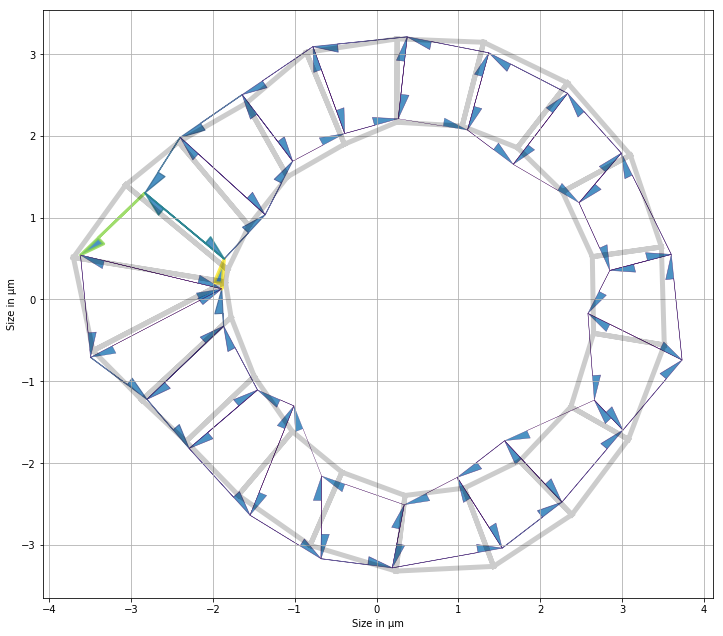

In [14]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

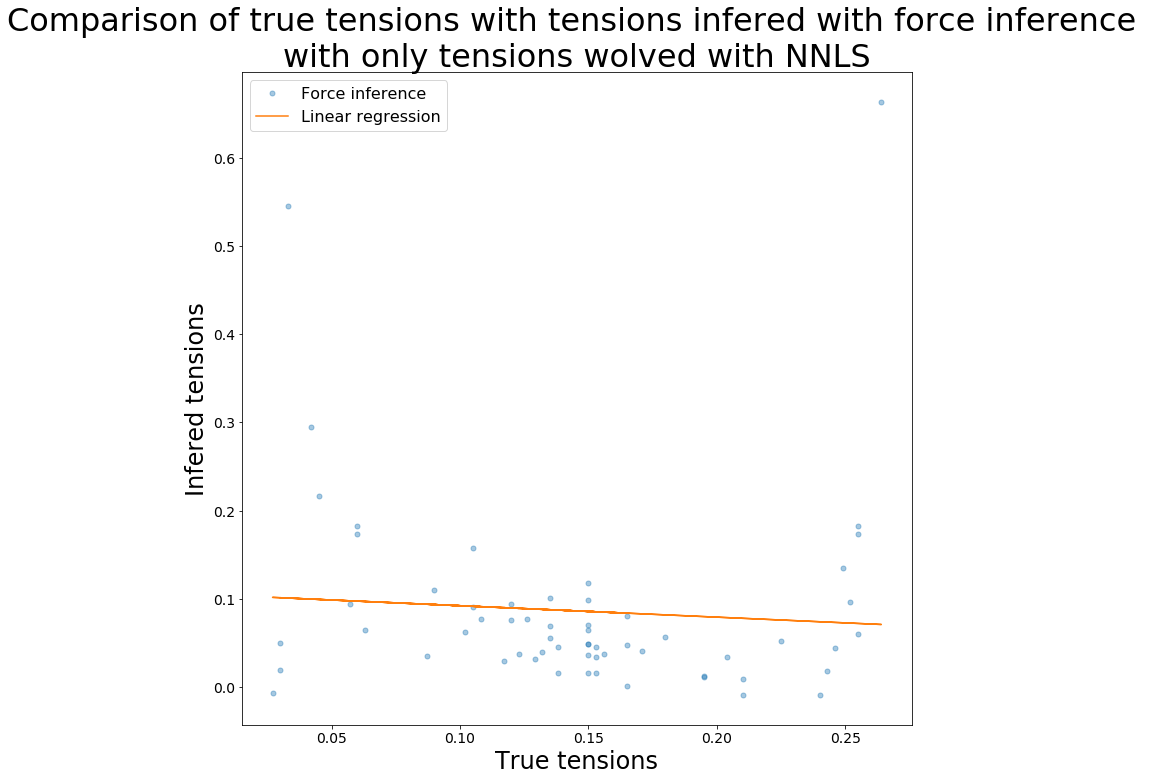

R value : -0.07375351944845718 
Standard error : 0.0975244758328035


In [15]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

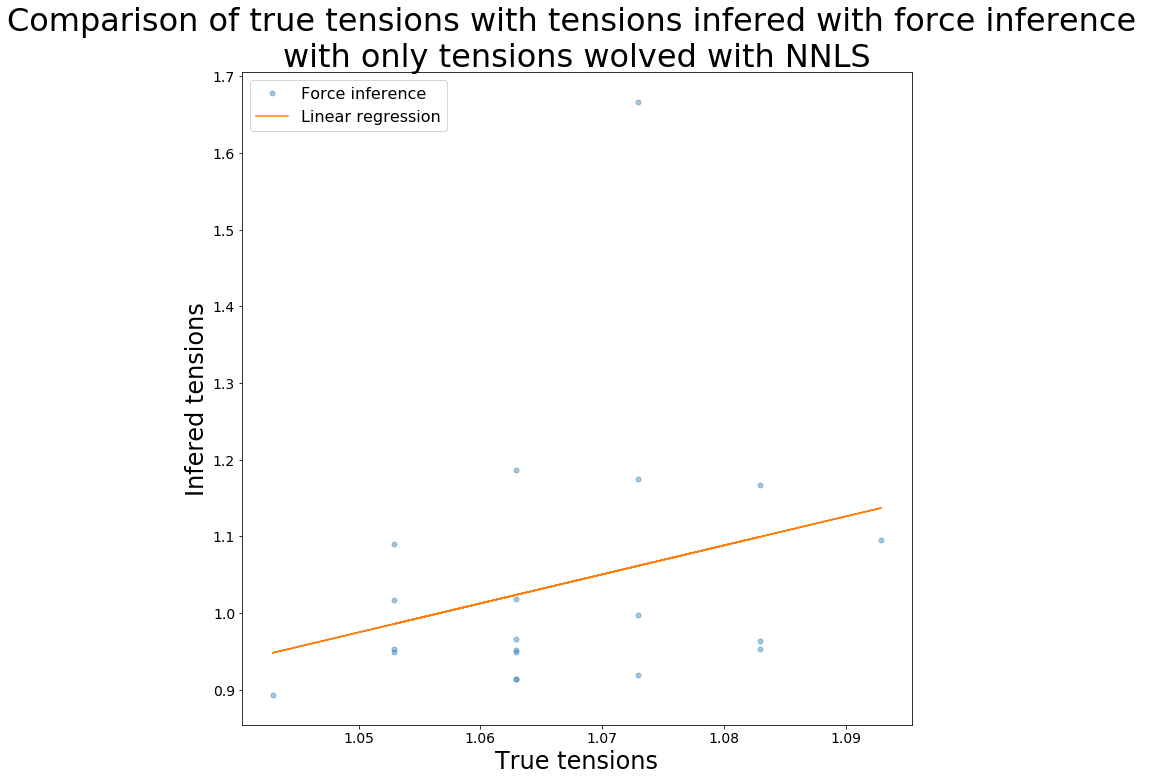

R value : 0.2755993332917628 
Standard error : 0.08151089286904774


In [16]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))